# Chapter 5 : Analysis

# Table of Contents 

* [Introduction](#introduction)
* [5.1 Statistical Analysis](#5.1)
    * [RQ1 - Impact of Gender on Badminton Participation](#RQ1) 
    * [RQ2 - Impact of Age on Badminton Participation](#RQ2)
    * [RQ3 - Impact of Deprivation on Badminton Participation](#RQ3)
    * [RQ4 - Impact of Disability on Badminton Participation](#RQ4)
    * [RQ5 - Impact of Ethnicity on Badminton Participation](#RQ5)
    * [RQ6 - Impact of Mosaic Group on Badminton Participation](#RQ6)
* [5.2 Temporal Analysis](#5.2)
* [5.3 County-Level Analysis](#5.3)
* [Conclusion](#conclusion)

## Introduction <a class="anchor" id="introduction"></a>

This chapter presents the detailed analysis conducted to understand the various factors influencing badminton participation. The analysis is structured around hypothesis testing for key research questions and includes a temporal analysis and county-level analysis to uncover significant patterns and relationships within the dataset. By testing various hypotheses, the study aims to provide evidence-based insights into how different factors such as gender, age, socio-economic status, ethnicity, and disability impact engagement in the sport. 

In [2]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import kruskal
import scikit_posthocs as sp
from scipy.stats import chi2
from scipy.stats import spearmanr
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import shapiro, mannwhitneyu

In [3]:
# loading the clean dataset
data = pd.read_csv("/Users/kuartina/Badminton England/data_BE.csv")

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 565247 entries, 0 to 565246
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   member_id             565247 non-null  object 
 1   year                  565247 non-null  int64  
 2   month                 565247 non-null  int64  
 3   county                565247 non-null  object 
 4   age                   565247 non-null  int64  
 5   gender                565247 non-null  object 
 6   mosaic                565247 non-null  object 
 7   deprivation           565247 non-null  float64
 8   ethnicity             565247 non-null  object 
 9   disability            565247 non-null  object 
 10  programme             565247 non-null  object 
 11  number_of_visits      565247 non-null  int64  
 12  age_category          565247 non-null  object 
 13  season                565247 non-null  object 
 14  region                565247 non-null  object 
 15  

### 5.1 Statistical Analysis <a class="anchor" id="5.1"></a>

### RQ1 - Impact of Gender on Badminton Participation <a class="anchor" id="RQ1"></a>

Research Question: Does gender affect the frequency of visits to badminton facilities?

Null Hypothesis (H0): There is no difference in the number of visits to badminton facilities between male and female members.

Alternative Hypothesis (HA): There is a difference in the number of visits to badminton facilities between male and female members.

In [10]:
# extracting visits data for male and female participants
male_visits = data[data['gender'] == 'M']['number_of_visits']
female_visits = data[data['gender'] == 'F']['number_of_visits']

# performing shapiro-wilk normality test
shapiro_male = shapiro(male_visits.sample(min(5000, len(male_visits)), random_state=1))
shapiro_female = shapiro(female_visits.sample(min(5000, len(female_visits)), random_state=1))

print(shapiro_male)
print(shapiro_female)

ShapiroResult(statistic=0.550719141960144, pvalue=0.0)
ShapiroResult(statistic=0.5013390779495239, pvalue=0.0)


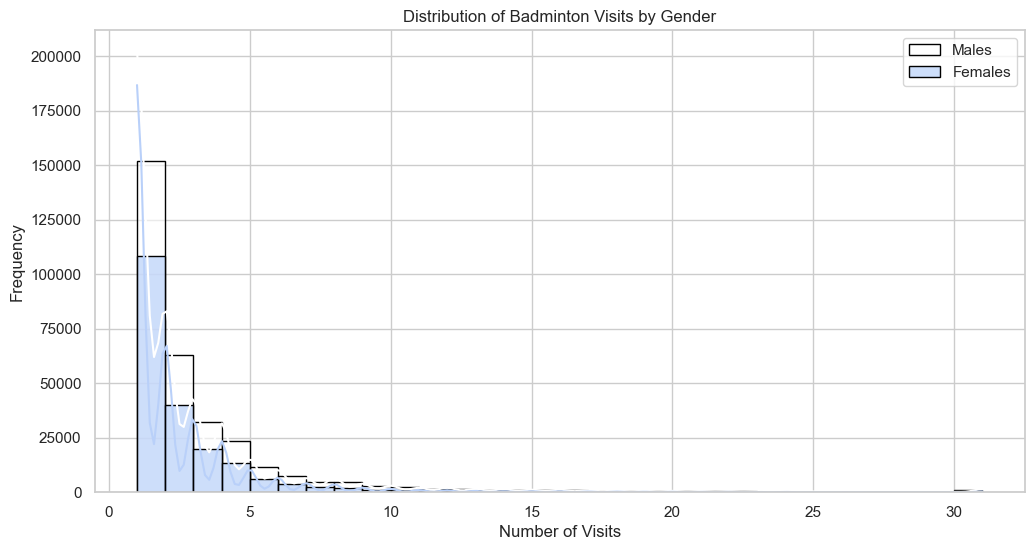

In [12]:
# setting the grid and palette
sns.set(style="whitegrid")
palette = sns.color_palette("coolwarm", 7)  # Using a diverging palette

# visualizing the distribution of visits for male and female participants
plt.figure(figsize=(12, 6))
sns.histplot(male_visits, color = 'white', kde=True, label='Males', alpha=0.6, bins=30, edgecolor='black')
sns.histplot(female_visits, color= palette[2], kde=True, label='Females', alpha=0.7, bins=30, edgecolor='black')
plt.legend()
plt.title('Distribution of Badminton Visits by Gender')
plt.xlabel('Number of Visits')
plt.ylabel('Frequency')
plt.show()

This suggests that non-parametric tests should be used for further statistical analysis, given the lack of normal distribution in the data.
Mann-Whitney U test should be used for further analysis. 

In [15]:
# choosing a non-parametric test: Mann-Whitney U Test since data is non-normal
stat_gender, p_value_gender = mannwhitneyu(male_visits, female_visits)
print("Mann-Whitney U Test Result - Statistic:", stat_gender, "P-value:", p_value_gender)

Mann-Whitney U Test Result - Statistic: 34635418841.5 P-value: 0.0


The extremely low p-value indicates a statistically significant difference, leading to the rejection of the null hypothesis.

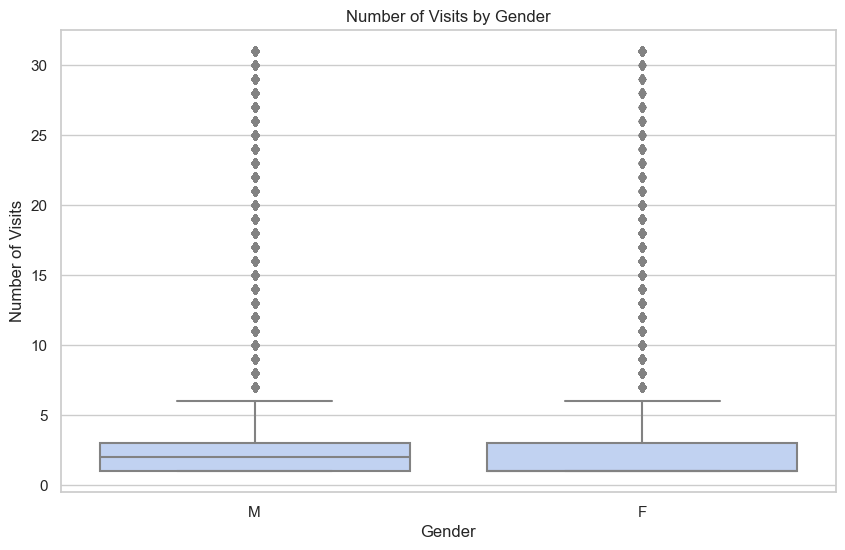

In [18]:
# visualizating to compare distributions
# setting the grid and palette
sns.set(style="whitegrid")
palette = sns.color_palette("coolwarm", 7)  # Using a diverging palette

# dropping 'Unknown' gender category
data_gender = data[data['gender'] != 'U']

plt.figure(figsize=(10, 6))
sns.boxplot(x='gender', y='number_of_visits', color=palette[2], data=data_gender)
plt.title('Number of Visits by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Visits')
plt.show()

In [20]:
# calculating the median and mean
statistics_gender = {
    "Gender": ["Male", "Female"],
    "Median Visits": [np.median(male_visits), np.median(female_visits)],
    "Mean Visits": [np.mean(male_visits), np.mean(female_visits)]
}

pd.DataFrame(statistics_gender)

,Gender,Median Visits,Mean Visits
0,Male,2.0,2.910773
1,Female,1.0,2.327642


##### Finding: Males participate more frequently in badminton than females, with higher median and mean visit frequencies.

### RQ2 - Impact of Age on Badminton Participation <a class="anchor" id="RQ2"></a>
Research Question: Does the frequency of visits to badminton facilities vary significantly across different age groups?

Null Hypothesis (H0): There is no difference in the number of visits to badminton facilities among age groups.

Alternative Hypothesis (HA): There is a difference in the number of visits to badminton facilities among age groups.


In [24]:
# grouping data by 'age_category' and performing shapiro-wilk test 
age_groups = data.groupby('age_category')
normality_results = {group: shapiro(sub_df['number_of_visits'].sample(min(5000, len(sub_df)), random_state=1))
                     for group, sub_df in age_groups}

pd.DataFrame(normality_results)

,Children (5-12),Middle-aged Adults (40-64),Seniors (65-95),Teenagers (13-19),Young Adults (20-39)
0,0.541579,0.537802,0.685979,0.507119,0.479699
1,0.000000,0.000000,0.000000,0.000000,0.000000


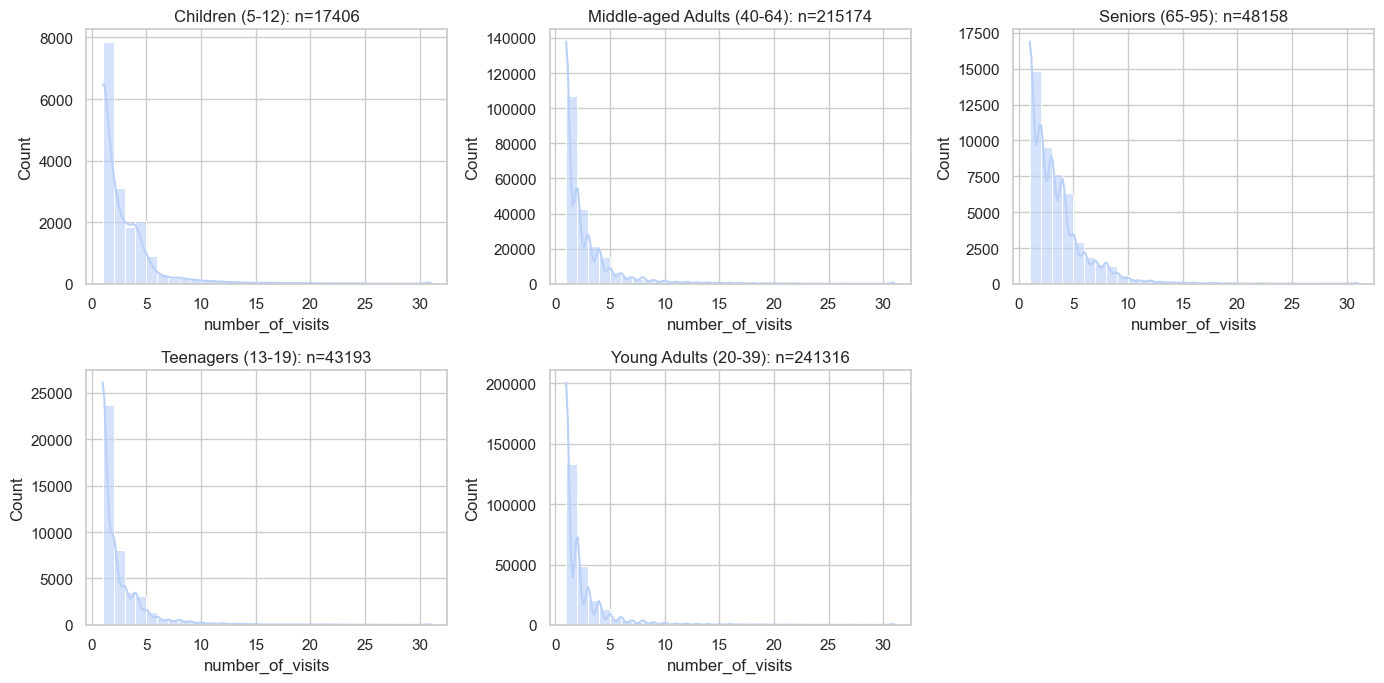

In [26]:
# setting the grid and palette
sns.set(style="whitegrid")
palette = sns.color_palette("coolwarm", 7)  # Using a diverging palette


# visualizing the visit distributions across age groups
plt.figure(figsize=(14, 7))
for i, (group, sub_df) in enumerate(age_groups, 1):
    plt.subplot(2, 3, i)
    sns.histplot(sub_df['number_of_visits'], color = palette[2], alpha=0.6, kde=True, bins=30)
    plt.title(f"{group}: n={len(sub_df)}")
plt.tight_layout()
plt.show()

Given the lack of normal distribution in the data, Non-parametric tests should be used for further statistical analysis. 
The Kruskal-Wallis test was selected for comparing visit frequencies among the age groups.

In [29]:
# removing any NaN values 
data_age = data.dropna(subset=['age_category', 'number_of_visits'])

# grouping data by deprivation category for the Kruskal-Wallis Test
age_groups = [data_age['number_of_visits'][data_age['age_category'] == cat].values for cat in data_age['age_category'].unique()]

# performing the Kruskal-Wallis Test
kw_stat_age, p_value_age = kruskal(*age_groups)
print("Kruskal-Wallis Test Statistic:", kw_stat_age)
print("P-Value:", p_value_age)

Kruskal-Wallis Test Statistic: 12752.805340794212
P-Value: 0.0


The extremely low p-value indicates a statistically significant difference in visit frequencies among the age groups, leading to the rejection of the null hypothesis.

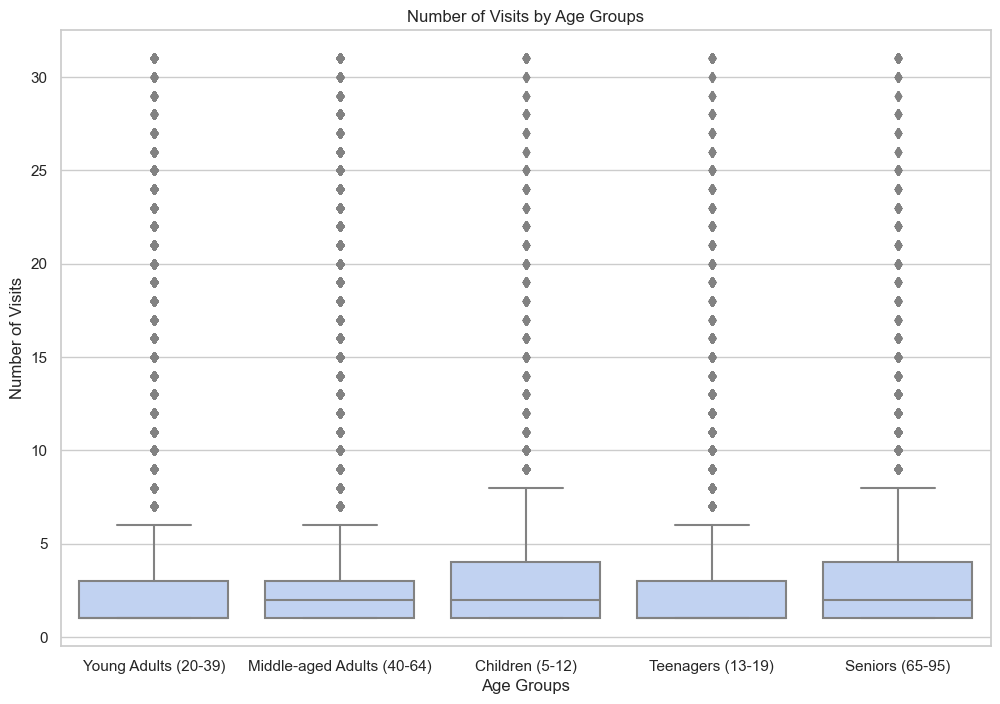

In [32]:
# visualizating to compare distributions
# setting the grid and palette
sns.set(style="whitegrid")
palette = sns.color_palette("coolwarm", 7)  # Using a diverging palette

data_age = data[data['age_category'] != 'U']

plt.figure(figsize=(12, 8))
sns.boxplot(x='age_category', y='number_of_visits', color=palette[2], data=data_gender)
plt.title('Number of Visits by Age Groups')
plt.xlabel('Age Groups')
plt.ylabel('Number of Visits')
plt.show()

In [34]:
# peforming post-hoc test
if p_value_age < 0.05:
    # Perform Dunn's Test with Bonferroni correction
    posthoc_age = sp.posthoc_dunn(data_age, val_col='number_of_visits', group_col='age_category', p_adjust='bonferroni')
pd.DataFrame(posthoc_age)

,Children (5-12),Middle-aged Adults (40-64),Seniors (65-95),Teenagers (13-19),Young Adults (20-39)
Children (5-12),1.000000e+00,7.667428e-46,4.528249e-244,1.868725e-131,4.840301e-219
Middle-aged Adults (40-64),7.667428e-46,1.000000e+00,0.000000e+00,6.485866e-90,0.000000e+00
Seniors (65-95),4.528249e-244,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
Teenagers (13-19),1.868725e-131,6.485866e-90,0.000000e+00,1.000000e+00,4.229643e-07
Young Adults (20-39),4.840301e-219,0.000000e+00,0.000000e+00,4.229643e-07,1.000000e+00


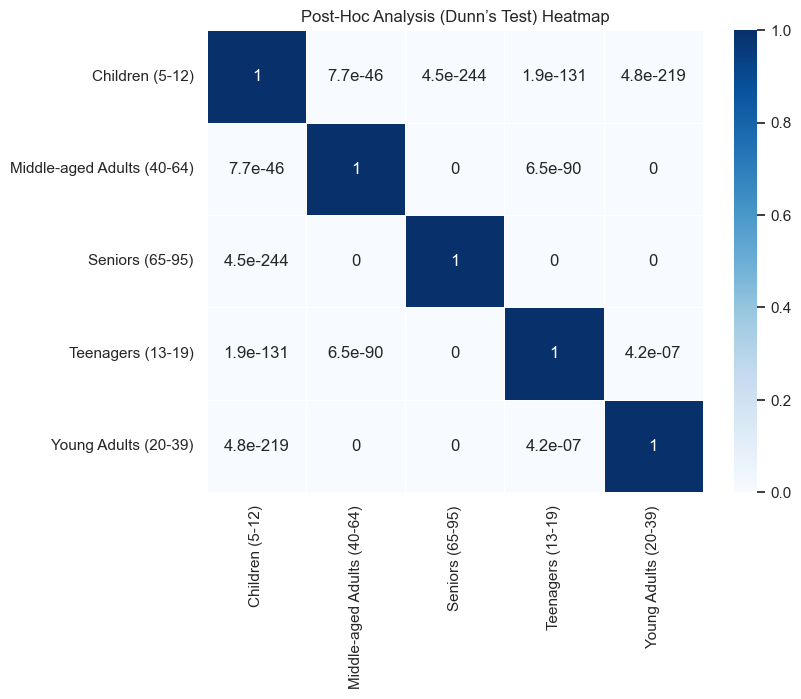

In [36]:
# visualizing the post-hoc test results
plt.figure(figsize=(8, 6))
sns.heatmap(posthoc_age, annot=True, cmap='Blues', linewidths=.5)
plt.title('Post-Hoc Analysis (Dunn’s Test) Heatmap')
plt.show()

Children vs. Young Adults: Significant difference, with young adults showing higher participation.

Teenagers vs. Seniors: Significant difference, with teenagers showing lower participation.

Middle-Aged Adults vs. Young Children: Significant difference, with middle-aged adults showing higher participation.

Young Adults vs. Seniors: Significant difference, with young adults showing higher participation.

These findings suggest that different age groups exhibit distinct patterns of engagement with badminton facilities.

##### Finding: Significant differences in badminton visit frequencies exist across various age groups. Younger adults (20-39) and middle-aged adults (40-64) exhibit higher participation rates compared to children (5-12) and teenagers (13-19).

### RQ3 - Impact of Deprivation on Badminton Participation <a class="anchor" id="RQ3"></a>
Research Question:  Does the level of deprivation affect the frequency of visits to badminton facilities?

Null Hypothesis (H0): There is no difference in the number of visits to badminton facilities across different levels of deprivation.

Alternative Hypothesis (HA): There is a difference in the number of visits to badminton facilities across different levels of deprivation.


In [41]:
# grouping data by 'deprivation_category'
deprivation_groups = data.groupby('deprivation_category')

# performing shapiro-wilk test for each deprivation level
normality_results_deprivation = {
    group: shapiro(sub_df['number_of_visits'].sample(min(5000, len(sub_df)), random_state=1))
    for group, sub_df in deprivation_groups
}
normality_results_deprivation

{'High': ShapiroResult(statistic=0.5495555996894836, pvalue=0.0),
 'Low': ShapiroResult(statistic=0.532090425491333, pvalue=0.0),
 'Medium': ShapiroResult(statistic=0.49419647455215454, pvalue=0.0)}

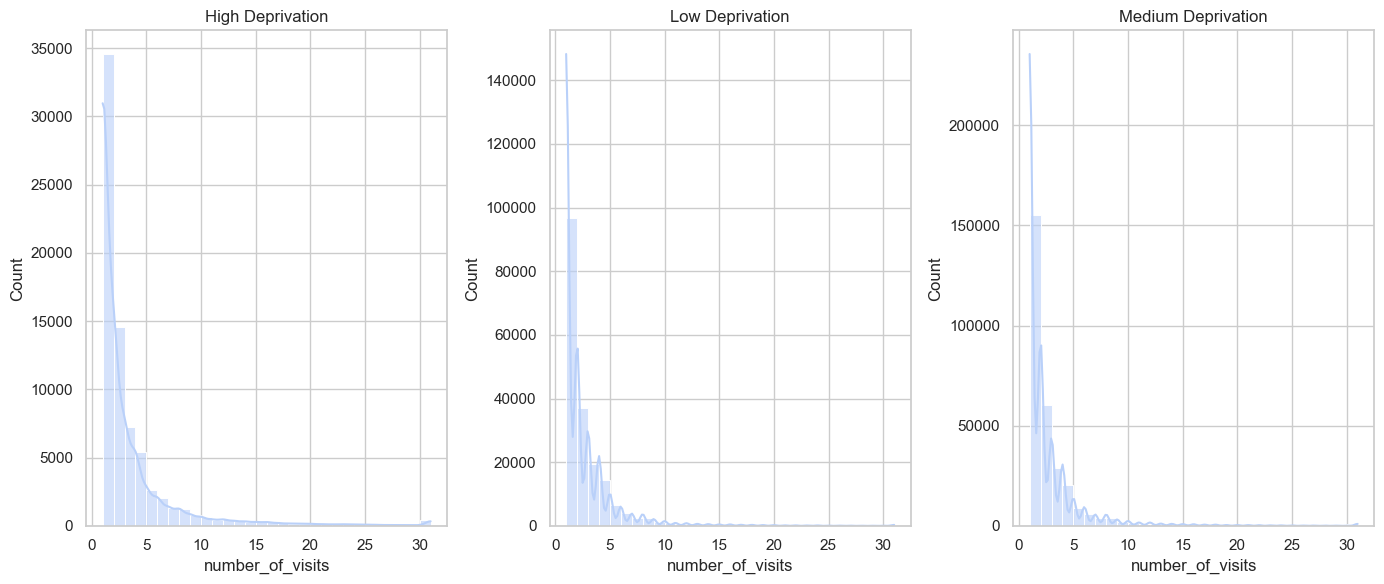

In [43]:
# visualizing the visit distributions across deprivation levels
# setting the grid and palette
sns.set(style="whitegrid")
palette = sns.color_palette("coolwarm", 7)  # Using a diverging palette

plt.figure(figsize=(14, 6))
for i, (group, sub_df) in enumerate(deprivation_groups, 1):
    plt.subplot(1, 3, i)
    sns.histplot(sub_df['number_of_visits'], color = palette[2], alpha=0.6, kde=True, bins=30)
    plt.title(f"{group} Deprivation")
plt.tight_layout()
plt.show()

None of the deprivation level groups' visit frequency distributions conform to a normal distribution.

Given the non-normal distribution of visit frequencies across deprivation levels, the Kruskal-Wallis test was selected for comparing visit frequencies among the deprivation levels.

In [45]:
# removing any NaN values
data_dep = data.dropna(subset=['deprivation_category', 'number_of_visits'])

# grouping data by deprivation category for the Kruskal-Wallis Test
deprivation_groups = [data_dep['number_of_visits'][data_dep['deprivation_category'] == cat].values for cat in data_dep['deprivation_category'].unique()]

# performing the Kruskal-Wallis Test
kw_stat_deprivation, p_value_deprivation = kruskal(*deprivation_groups)
print("Kruskal-Wallis Test Statistic:", kw_stat_deprivation)
print("P-Value:", p_value_deprivation)

Kruskal-Wallis Test Statistic: 1373.331617694827
P-Value: 6.092959704320404e-299


The extremely low p-value indicates a statistically significant difference in visit frequencies among the deprivation levels, leading to the rejection of the null hypothesis.

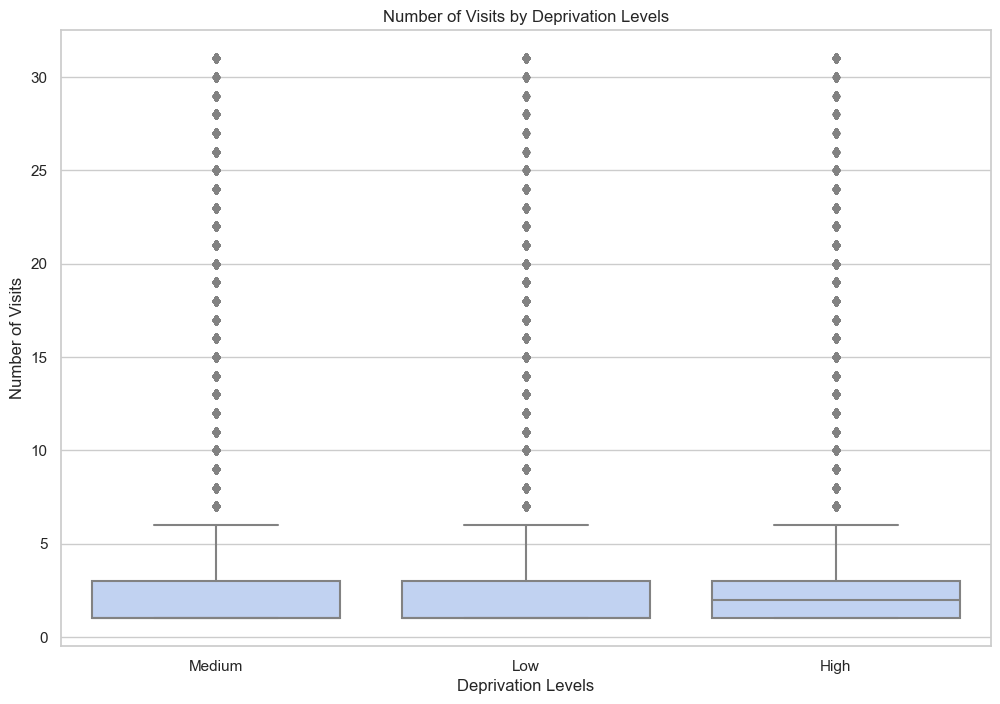

In [47]:
# visualizating to compare distributions
data_dep = data[data['deprivation_category'] != 'U']
# setting the grid and palette
sns.set(style="whitegrid")
palette = sns.color_palette("coolwarm", 7)  # Using a diverging palette


plt.figure(figsize=(12, 8))
sns.boxplot(x='deprivation_category', y='number_of_visits', color=palette[2], data=data_gender)
plt.title('Number of Visits by Deprivation Levels')
plt.xlabel('Deprivation Levels')
plt.ylabel('Number of Visits')
plt.show()

In [49]:
# performing post-hoc test
if p_value_deprivation < 0.05:
    # Perform Dunn's Test with Bonferroni correction
    posthoc_dep = sp.posthoc_dunn(data_dep, val_col='number_of_visits', group_col='deprivation_category', p_adjust='bonferroni')
pd.DataFrame(posthoc_dep)

,High,Low,Medium
High,1.000000e+00,1.829980e-202,4.602558e-297
Low,1.829980e-202,1.000000e+00,8.989374e-11
Medium,4.602558e-297,8.989374e-11,1.000000e+00


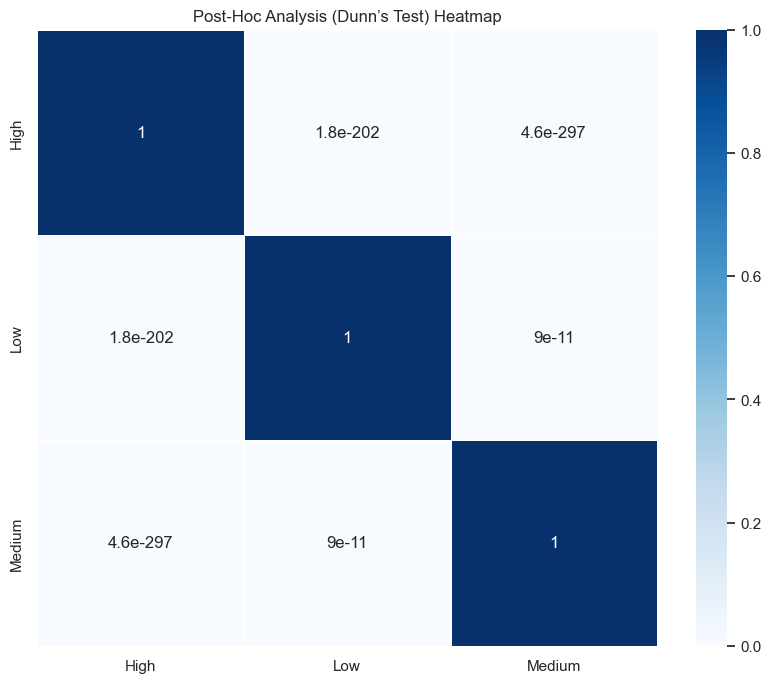

In [51]:
# visualizing the post-hoc results
plt.figure(figsize=(10, 8))
sns.heatmap(posthoc_dep, annot=True, cmap='Blues', linewidths=.5)
plt.title('Post-Hoc Analysis (Dunn’s Test) Heatmap')
plt.show()

In [53]:
# Group by deprivation category and calculate mean and median
summary_stats = data.groupby('deprivation_category')['number_of_visits'].agg(['mean', 'median']).reset_index()
print(summary_stats)

  deprivation_category      mean  median
0                 High  3.243133     2.0
1                  Low  2.518733     1.0
2               Medium  2.569233     1.0


##### Finding : Significant differences in participation rates exist among different deprivation levels, with higher deprivation areas showing higher participation rates.

### RQ4 - Impact of Disability on Badminton Participation <a class="anchor" id="RQ4"></a>
Research Question: Does disability status affect the frequency of visits to badminton facilities?

Null Hypothesis (H0): There is no difference in the number of visits to badminton facilities between members with and without disabilities.

Alternative Hypothesis (HA): There is a difference in the number of visits to badminton facilities between members with and without disabilities.


In [57]:
# filtering out 'Unknown' entries for disability
data_dis = data[data['disability'] != 'Unknown']

# extracting visits data for participants with and without disabilities
yes_dis = data_dis[data_dis['disability'] == 'Yes']['number_of_visits']
no_dis = data_dis[data_dis['disability'] == 'No']['number_of_visits']

# performing dhapiro-wilk normality tests
shapiro_yes = shapiro(yes_dis.sample(min(5000, len(yes_dis)), random_state=1))
shapiro_no = shapiro(no_dis.sample(min(5000, len(no_dis)), random_state=1))

shapiro_yes, shapiro_no

(ShapiroResult(statistic=0.6242471933364868, pvalue=0.0),
 ShapiroResult(statistic=0.5864658355712891, pvalue=0.0))

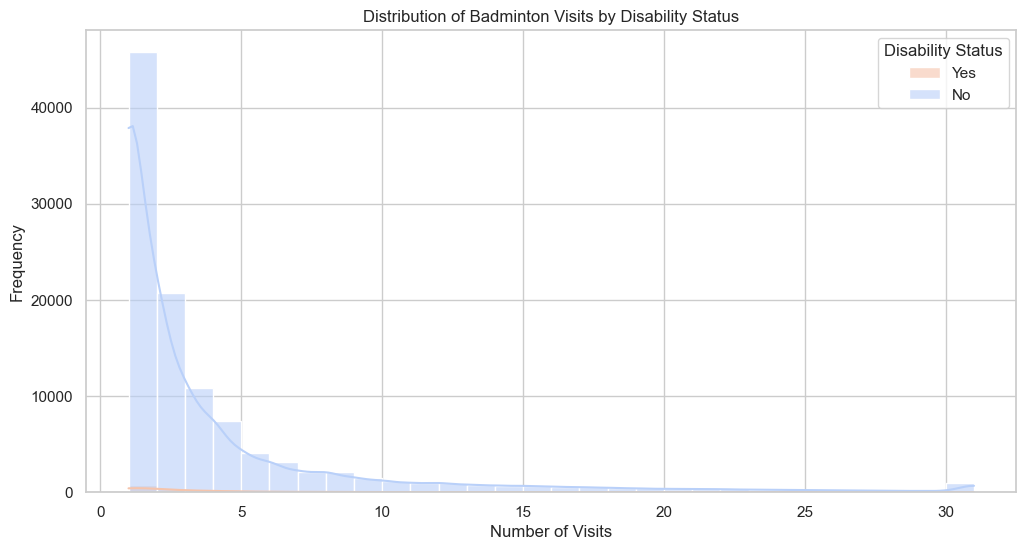

In [59]:
# setting the grid and palette
sns.set(style="whitegrid")
palette = sns.color_palette("coolwarm", 7)  # Using a diverging palette

# visualizing the distribution of visits for participants by disability status
plt.figure(figsize=(12, 6))
sns.histplot(yes_dis, color=palette[4], kde=True, label='Yes', alpha=0.6, bins=30)
sns.histplot(no_dis, color=palette[2], kde=True, label='No', alpha=0.6, bins=30)
plt.legend(title='Disability Status')
plt.title('Distribution of Badminton Visits by Disability Status')
plt.xlabel('Number of Visits')
plt.ylabel('Frequency')
plt.show()

The distribution of badminton visits by disability status () shows that both groups have highly skewed distributions. Given the non-normal distribution of visit frequencies for both groups, the Mann-Whitney U test was selected for comparing the visit frequencies between members with and without disabilities.

In [62]:
# choosing a non-parametric test: Mann-Whitney U Test since data is non-normal
stat_dis, p_value_dis = mannwhitneyu(yes_dis, no_dis)
print("Mann-Whitney U Test Result - Statistic:", stat_dis, "P-value:", p_value_dis)

Mann-Whitney U Test Result - Statistic: 91497019.0 P-value: 0.1881802546455723


The p-value is above the significance level of 0.05, indicating no statistically significant difference in visit frequencies between members with and without disabilities, leading to the failure to reject the null hypothesis.

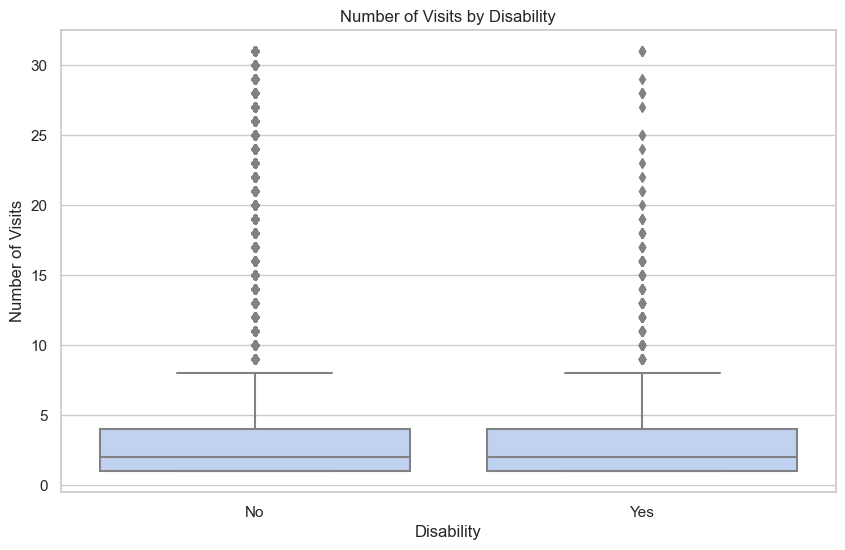

In [65]:
# dropping 'Unknown' 
data_dis = data[data['disability'] != 'Unknown']

# setting the grid and palette
sns.set(style="whitegrid")
palette = sns.color_palette("coolwarm", 7)  # Using a diverging palette

plt.figure(figsize=(10, 6))
sns.boxplot(x='disability', y='number_of_visits', color=palette[2], data=data_dis)
plt.title('Number of Visits by Disability')
plt.xlabel('Disability')
plt.ylabel('Number of Visits')
plt.show()

In [67]:
# calculating the median and mean
statistics_dis = {
    "Disability": ["Yes", "No"],
    "Median Visits": [np.median(yes_dis), np.median(no_dis)],
    "Mean Visits": [np.mean(yes_dis), np.mean(no_dis)]
}

pd.DataFrame(statistics_dis)

,Disability,Median Visits,Mean Visits
0,Yes,2.0,3.376163
1,No,2.0,3.866028


Although the mean visits are slightly higher for members without disabilities, the difference is not statistically significant based on the Mann-Whitney U test results.

##### Finding : There are no significant differences in badminton participation frequencies between members with and without disabilities within the studied population.

### RQ5 - Impact of Ethnicity on Badminton Participation <a class="anchor" id="RQ5"></a>
Research Question: Does ethnicity affect the frequency of visits to badminton facilities?

Null Hypothesis (H0): There is no difference in the number of visits to badminton facilities among different ethnic groups.

Alternative Hypothesis (HA): There is a difference in the number of visits to badminton facilities among different ethnic groups.

In [72]:
# filtering out 'Unknown' entries 
data_eth = data[data['ethnicity'] != 'Unknown']

# grouping data by 'ethnicity' and performing shapiro-wilk test on 'number_of_visits'
eth_groups = data_eth.groupby('ethnicity')
normality_results_eth = {group: shapiro(sub_df['number_of_visits'].sample(min(5000, len(sub_df)), random_state=1))
                     for group, sub_df in eth_groups}

pd.DataFrame(normality_results_eth)

,Asian,Black,Mixed,Other,White
0,0.636141,0.580254,0.544509,0.566574,0.533924
1,0.000000,0.000000,0.000000,0.000000,0.000000


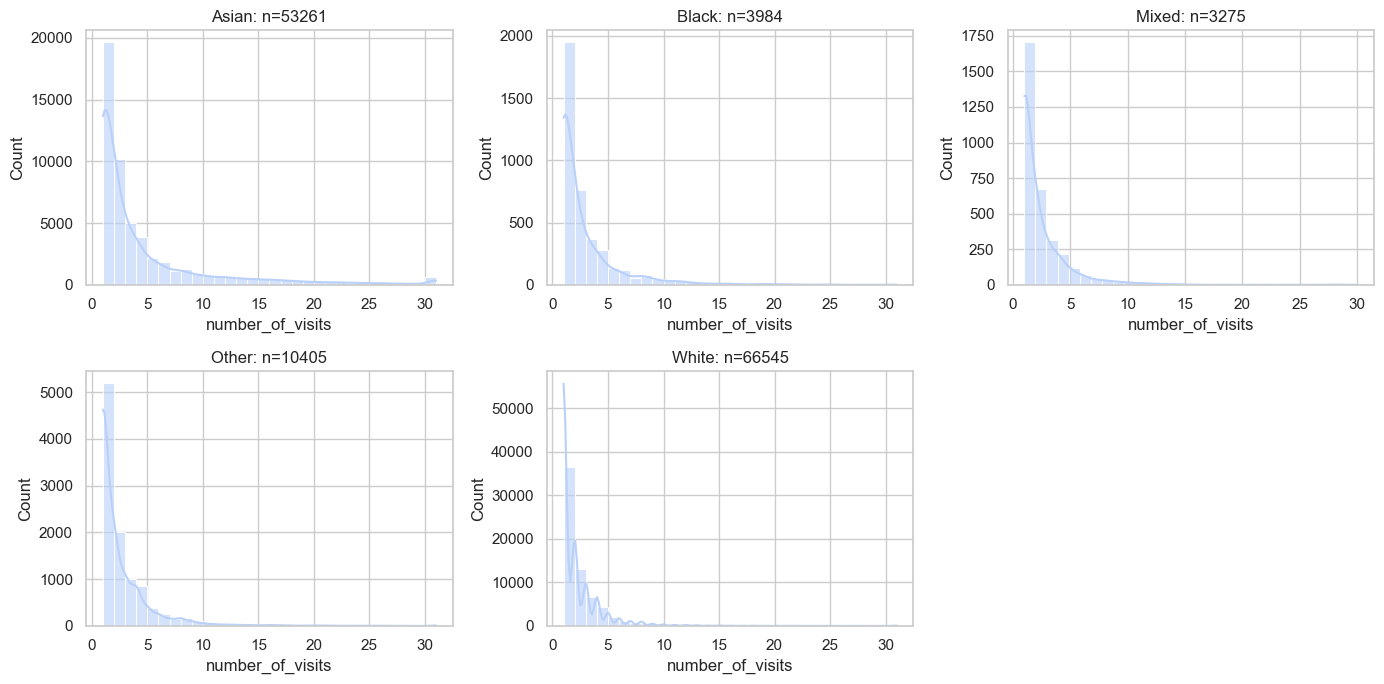

In [74]:
# visualizing the distribution of visits for participants by ethnic groups
# setting the grid and palette
sns.set(style="whitegrid")
palette = sns.color_palette("coolwarm", 7)  # Using a diverging palette

plt.figure(figsize=(14, 7))
for i, (group, sub_df) in enumerate(eth_groups, 1):
    plt.subplot(2, 3, i)
    sns.histplot(sub_df['number_of_visits'], color = palette[2], alpha=0.6, kde=True, bins=30)
    plt.title(f"{group}: n={len(sub_df)}")
plt.tight_layout()
plt.show()

None of the ethnic groups' visit frequency distributions conform to a normal distribution. Given the non-normal distribution of visit frequencies among all ethnic groups, the Kruskal-Wallis test was selected for comparing the visit frequencies across these groups.

In [77]:
#  removing any NaN values 
data_eth = data[data['ethnicity'] != 'Unknown']

# grouping data by ethnic groups for the kruskal-wallis test
eth_groups = [data_eth['number_of_visits'][data_eth['ethnicity'] == cat].values for cat in data_eth['ethnicity'].unique()]

# performing the kruskal-wallis test
kw_stat_eth, p_value_eth = kruskal(*eth_groups)
print("Kruskal-Wallis Test Statistic:", kw_stat_eth)
print("P-Value:", p_value_eth)

Kruskal-Wallis Test Statistic: 6883.059949363102
P-Value: 0.0


The extremely low p-value indicates a statistically significant difference, leading to the rejection of the null hypothesis. 

In [80]:
# performing post-hoc test
if p_value_eth < 0.05:
    # Perform Dunn's Test with Bonferroni correction
    posthoc_eth = sp.posthoc_dunn(data_eth, val_col='number_of_visits', group_col='ethnicity', p_adjust='bonferroni')
pd.DataFrame(posthoc_eth)

,Asian,Black,Mixed,Other,White
Asian,1.000000e+00,1.149869e-80,2.713988e-116,3.875881e-236,0.000000e+00
Black,1.149869e-80,1.000000e+00,2.193883e-04,4.107643e-01,1.723801e-22
Mixed,2.713988e-116,2.193883e-04,1.000000e+00,1.955897e-02,4.506842e-03
Other,3.875881e-236,4.107643e-01,1.955897e-02,1.000000e+00,2.346081e-31
White,0.000000e+00,1.723801e-22,4.506842e-03,2.346081e-31,1.000000e+00


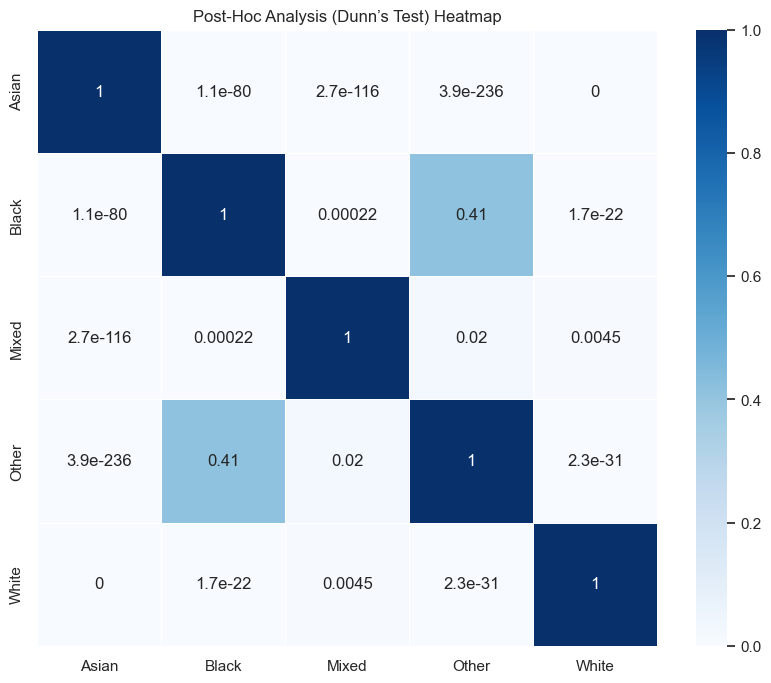

In [82]:
# visualizing the post-hoc results
plt.figure(figsize=(10, 8))
sns.heatmap(posthoc_eth, annot=True, cmap='Blues', linewidths=.5)
plt.title('Post-Hoc Analysis (Dunn’s Test) Heatmap')
plt.show()

In [84]:
# Group by deprivation category and calculate mean and median
summary_eth = data.groupby('ethnicity')['number_of_visits'].agg(['mean', 'median']).reset_index()
print(summary_eth)

  ethnicity      mean  median
0     Asian  4.607030     2.0
1     Black  2.844629     2.0
2     Mixed  2.388397     1.0
3     Other  2.585296     2.0
4   Unknown  2.464894     1.0
5     White  2.212097     1.0


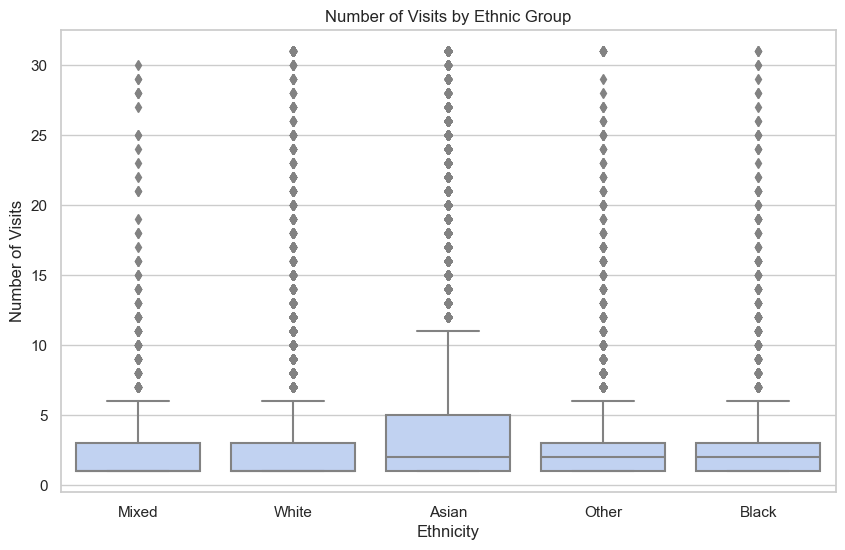

In [86]:
# setting the grid and palette
sns.set(style="whitegrid")
palette = sns.color_palette("coolwarm", 7)  # Using a diverging palette

plt.figure(figsize=(10, 6))
sns.boxplot(x='ethnicity', y='number_of_visits', color=palette[2], data=data_eth)
plt.title('Number of Visits by Ethnic Group')
plt.xlabel('Ethnicity')
plt.ylabel('Number of Visits')
plt.show()

##### Finding : The Asian ethnic group shows the highest level of engagement with badminton facilities, as indicated by a higher median and greater variability in the number of visits. Other ethnic groups (Mixed, White, Black, Other) show similar patterns of engagement, with lower medians and less variability in visit frequencies. 

### RQ6 - Impact of Mosaic Group on Badminton Participation  <a class="anchor" id="RQ6"></a>

Research Question: Does the Mosaic Group classification affect the frequency of visits to badminton facilities?

Null Hypothesis (H0): There is no difference in the number of visits to badminton facilities among different Mosaic Groups.

Alternative Hypothesis (HA): There is a difference in the number of visits to badminton facilities among different Mosaic Groups.

In [90]:
# filtering out 'Unknown' entries
data_mosaic = data[data['mosaic'] != 'Unknown']

# grouping data by 'mosaic' and performing shapiro-wilk test on 'number_of_visits'
mosaic_groups = data_mosaic.groupby('mosaic')
normality_results_mosaic = {group: shapiro(sub_df['number_of_visits'].sample(min(5000, len(sub_df)), random_state=1))
                            for group, sub_df in mosaic_groups}

pd.DataFrame(normality_results_mosaic)

,A City Prosperity,B Prestige Positions,C Country Living,D Rural Reality,E Senior Security,F Suburban Stability,G Domestic Success,H Aspiring Homemakers,I Family Basics,J Transient Renters,K Municipal Tenants,L Vintage Value,M Modest Traditions,N Urban Cohesion,O Rental Hubs
0,0.554148,0.576066,0.647574,0.624984,0.526724,0.571779,0.548238,0.511632,0.533493,0.529466,0.580382,0.53783,0.480368,0.573177,0.558798
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000


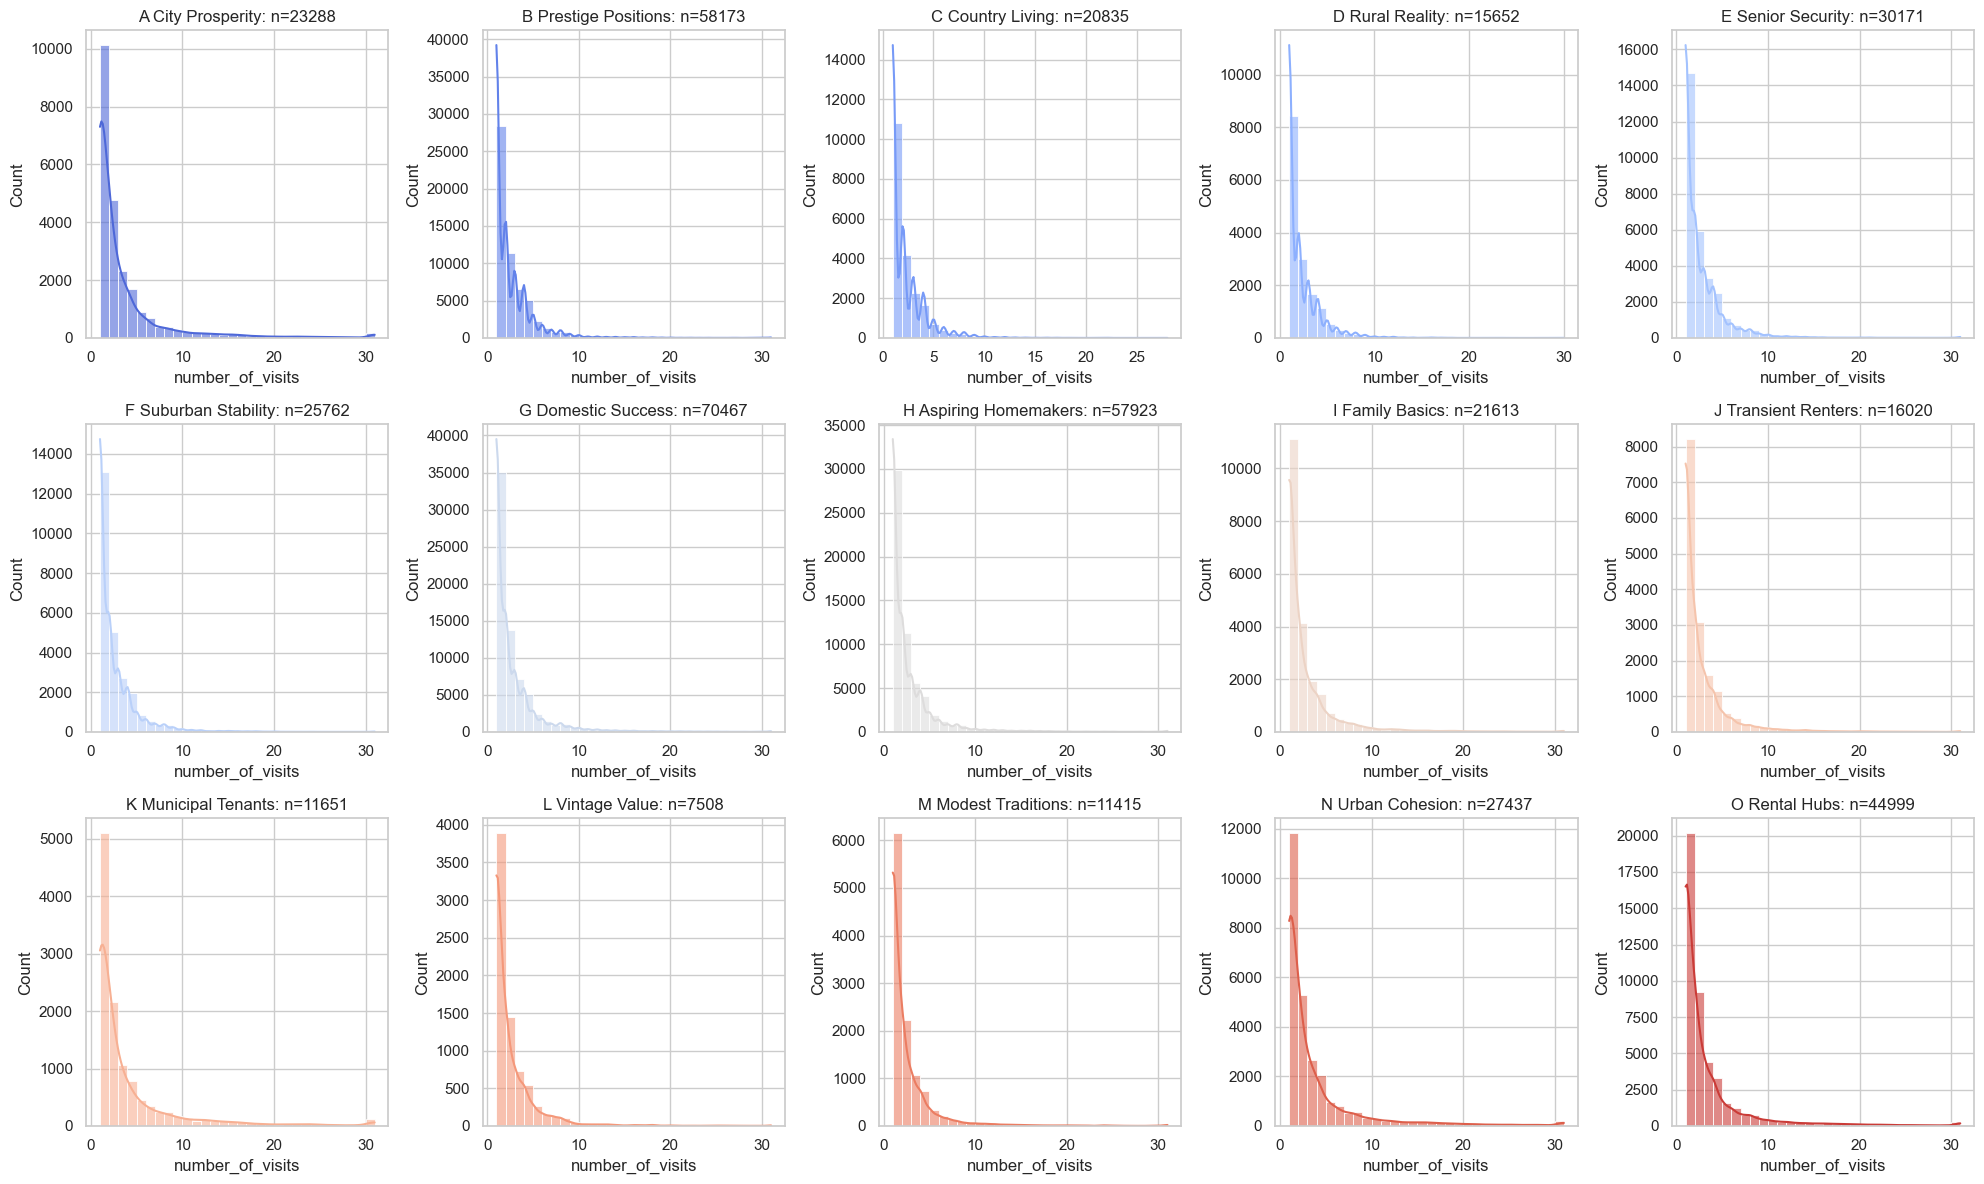

In [92]:
# visualizing the distribution of visits for participants by Mosaic groups
# setting the grid and palette
sns.set(style="whitegrid")
palette = sns.color_palette("coolwarm", 15)  # Using a diverging palette

plt.figure(figsize=(20, 12))
for i, (group, sub_df) in enumerate(mosaic_groups, 1):
    plt.subplot(3, 5, i)  # Adjust the grid to fit all Mosaic groups (assuming there are 15 groups)
    sns.histplot(sub_df['number_of_visits'], color=palette[i-1], alpha=0.6, kde=True, bins=30)
    plt.title(f"{group}: n={len(sub_df)}")
plt.tight_layout()
plt.show()

The distribution of badminton visits by mosaic groups shows that all groups have highly skewed distributions. 

In [95]:
#  removing any NaN values 
data_mosaic = data[data['mosaic'] != 'Unknown']

# grouping data by mosaic groups for the kruskal-wallis test
mosaic_groups = [data_mosaic['number_of_visits'][data_mosaic['mosaic'] == cat].values for cat in data_mosaic['mosaic'].unique()]

# performing the kruskal-wallis test
kw_stat_mos, p_value_mos = kruskal(*mosaic_groups)
print("Kruskal-Wallis Test Statistic:", kw_stat_mos)
print("P-Value:", p_value_mos)

Kruskal-Wallis Test Statistic: 2986.2868355365963
P-Value: 0.0


The extremely low p-value indicates a statistically significant difference, leading to the rejection of the null hypothesis. 

In [98]:
# performing post-hoc test
if p_value_mos < 0.05:
    # Perform Dunn's Test with Bonferroni correction
    posthoc_mos = sp.posthoc_dunn(data_mosaic, val_col='number_of_visits', group_col='mosaic', p_adjust='bonferroni')
pd.DataFrame(posthoc_mos)

,A City Prosperity,B Prestige Positions,C Country Living,D Rural Reality,E Senior Security,F Suburban Stability,G Domestic Success,H Aspiring Homemakers,I Family Basics,J Transient Renters,K Municipal Tenants,L Vintage Value,M Modest Traditions,N Urban Cohesion,O Rental Hubs
A City Prosperity,1.000000e+00,1.765085e-79,4.367998e-127,3.719729e-138,1.857535e-60,5.495740e-96,8.667912e-93,6.037907e-139,1.939083e-78,2.739796e-73,7.700663e-01,7.489058e-51,1.327677e-106,1.289159e-01,1.654655e-03
B Prestige Positions,1.765085e-79,1.000000e+00,2.363911e-22,1.215973e-33,1.000000e+00,2.633532e-06,1.000000e+00,3.742485e-14,9.713593e-03,6.905906e-04,2.319972e-67,8.137575e-04,1.557256e-22,3.977557e-127,6.182787e-71
C Country Living,4.367998e-127,2.363911e-22,1.000000e+00,4.811716e-01,3.995540e-19,1.417112e-03,4.215302e-19,2.163690e-03,1.478376e-05,6.630491e-03,1.187782e-110,1.000000e+00,1.000000e+00,3.439980e-173,1.421468e-118
D Rural Reality,3.719729e-138,1.215973e-33,4.811716e-01,1.000000e+00,1.804355e-29,3.572575e-10,3.580572e-30,9.290666e-11,1.157907e-12,1.540310e-08,5.998901e-123,4.553042e-03,1.000000e+00,2.059058e-181,1.341453e-128
E Senior Security,1.857535e-60,1.000000e+00,3.995540e-19,1.804355e-29,1.000000e+00,1.669780e-05,1.000000e+00,1.062126e-10,1.491449e-02,1.157690e-03,1.647358e-56,8.360424e-04,1.443647e-20,6.192338e-95,5.299865e-48
F Suburban Stability,5.495740e-96,2.633532e-06,1.417112e-03,3.572575e-10,1.669780e-05,1.000000e+00,3.536058e-04,1.000000e+00,1.000000e+00,1.000000e+00,9.955136e-85,1.000000e+00,2.210621e-06,2.667196e-138,1.045598e-85
G Domestic Success,8.667912e-93,1.000000e+00,4.215302e-19,3.580572e-30,1.000000e+00,3.536058e-04,1.000000e+00,1.063044e-10,2.901751e-01,2.308906e-02,1.202123e-75,1.148172e-02,8.596098e-20,6.766106e-147,7.770711e-88
H Aspiring Homemakers,6.037907e-139,3.742485e-14,2.163690e-03,9.290666e-11,1.062126e-10,1.000000e+00,1.063044e-10,1.000000e+00,1.000000e+00,1.000000e+00,2.912965e-108,1.000000e+00,2.972489e-06,7.918753e-205,3.061182e-143
I Family Basics,1.939083e-78,9.713593e-03,1.478376e-05,1.157907e-12,1.491449e-02,1.000000e+00,2.901751e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.886577e-72,1.000000e+00,2.149101e-08,5.597058e-114,2.651283e-66
J Transient Renters,2.739796e-73,6.905906e-04,6.630491e-03,1.540310e-08,1.157690e-03,1.000000e+00,2.308906e-02,1.000000e+00,1.000000e+00,1.000000e+00,2.971894e-70,1.000000e+00,1.470126e-05,7.704862e-104,1.407197e-60


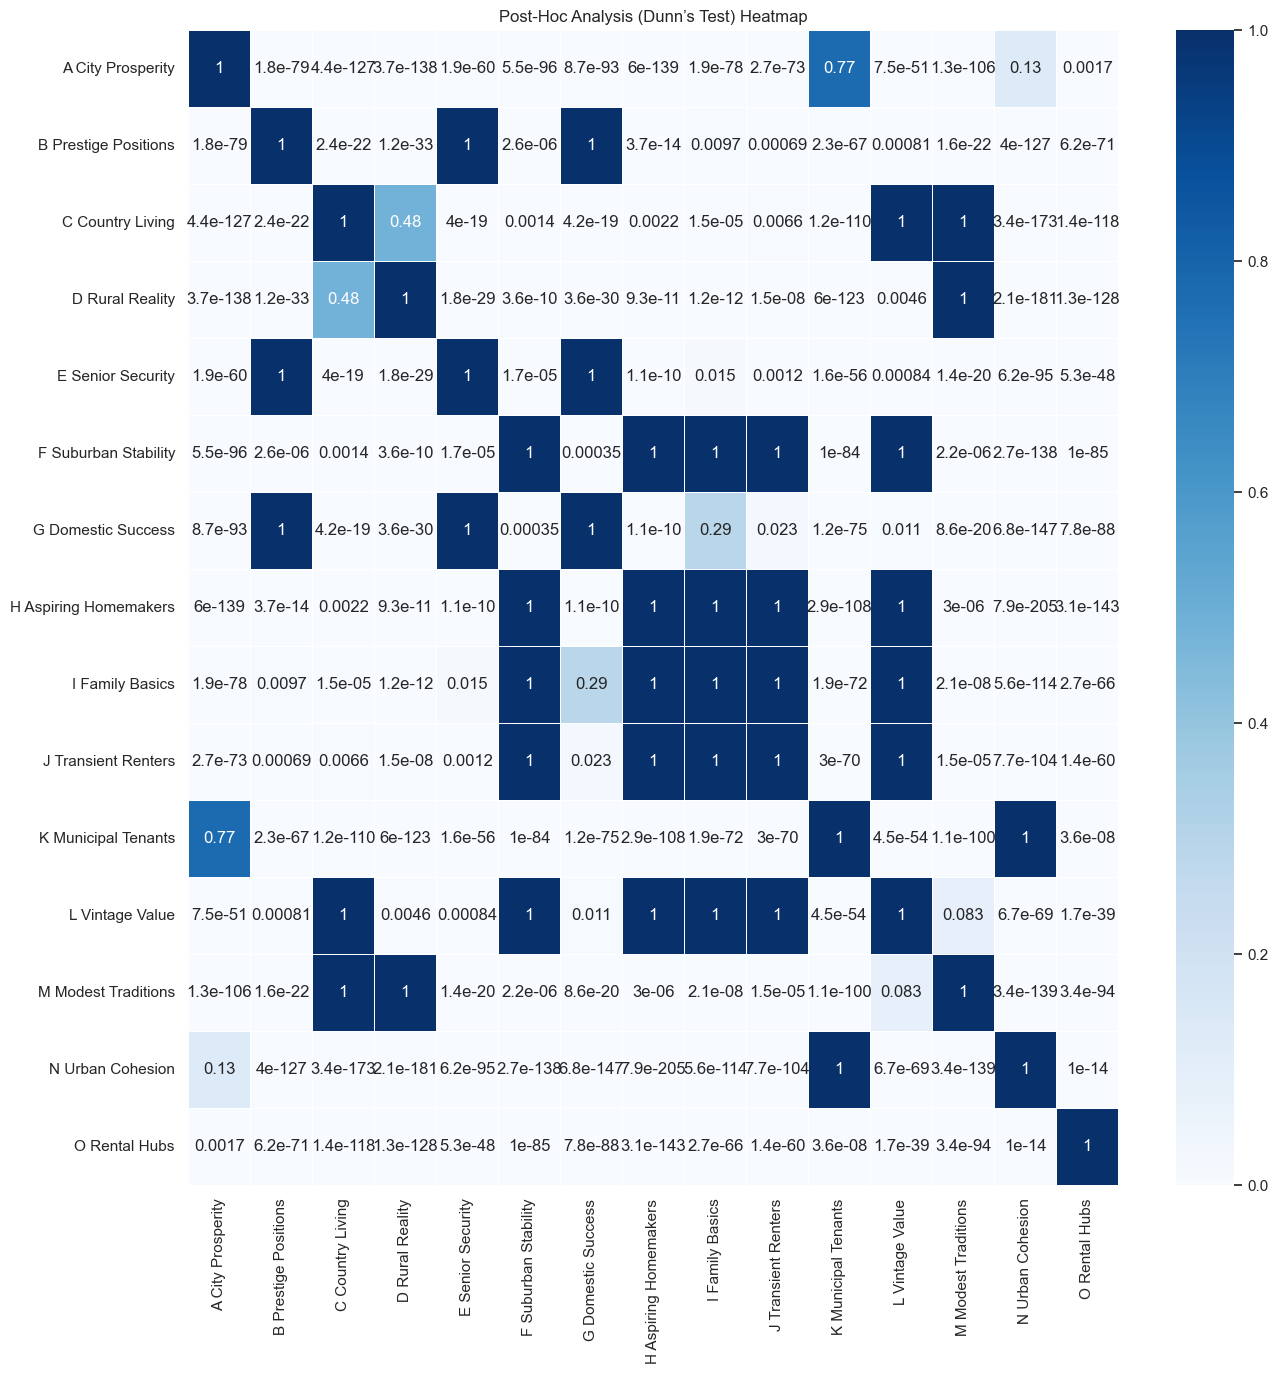

In [99]:
# visualizing the post-hoc results
plt.figure(figsize=(15, 15))
sns.heatmap(posthoc_mos, annot=True, cmap='Blues', linewidths=.5)
plt.title('Post-Hoc Analysis (Dunn’s Test) Heatmap')
plt.show()

The cells comparing K Municipal Tenants with A City Prosperity (p = 0.77) and N Urban Cohesion with A City Prosperity (p = 0.13) show lighter colours, indicating no significant difference in the number of visits between these groups. Other cells such as those comparing G Domestic Success with several other groups, show very low p-values (dark colours), indicating significant differences in the number of visits.

### 5.2 Temporal Analysis <a class="anchor" id="5.2"></a>

In [104]:
# converting the 'date' column to datetime format for easier manipulation
data['date'] = pd.to_datetime(data['date'])

# extracting month and season from the date
data['month'] = data['date'].dt.month
data['season'] = data['date'].dt.month % 12 // 3 + 1
season_dict = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Autumn'}
data['season'] = data['season'].map(season_dict)

# aggregating the data by month and season
monthly_participation = data.groupby('month')['number_of_visits'].sum().reset_index()
seasonal_participation = data.groupby('season')['number_of_visits'].sum().reset_index()

# settingthe month order
month_order = {4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec', 1: 'Jan', 2: 'Feb', 3: 'Mar'}
monthly_participation['month_name'] = monthly_participation['month'].map(month_order)

monthly_participation = monthly_participation.set_index('month').loc[list(month_order.keys())].reset_index()

In [106]:
pd.DataFrame(monthly_participation) 

,month,number_of_visits,month_name
0,4,120866,Apr
1,5,122641,May
2,6,116568,Jun
3,7,133747,Jul
4,8,135137,Aug
5,9,119522,Sep
6,10,135235,Oct
7,11,128797,Nov
8,12,85599,Dec
9,1,128800,Jan


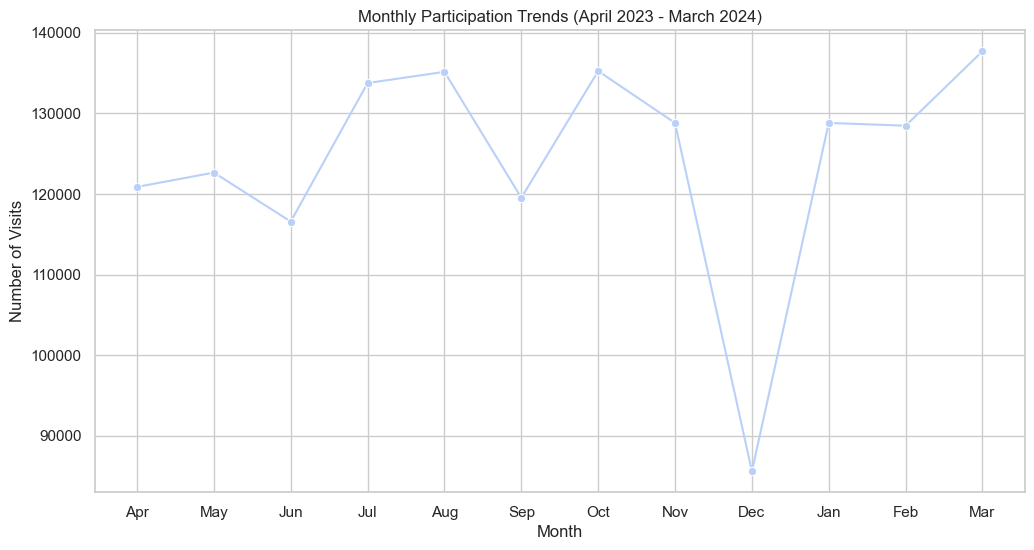

In [108]:
# setting the grid and palette
sns.set(style="whitegrid")
palette = sns.color_palette("coolwarm", 7)  # Using a diverging palette
# visualising monthly participation trends 
plt.figure(figsize=(12, 6))
sns.lineplot(x='month_name', y='number_of_visits', data=monthly_participation, marker='o', color=palette[2])
plt.xlabel('Month')
plt.ylabel('Number of Visits')
plt.title('Monthly Participation Trends (April 2023 - March 2024)')
plt.grid(True)
plt.show()

The analysis of monthly badminton participation from April 2023 to March 2024 reveals significant fluctuations throughout the year. Peak participation is observed in March 2024 with nearly 140,000 visits, followed by high engagement in July, August, and October, each exceeding 130,000 visits. Conversely, the lowest participation occurs in December 2023, dropping below 90,000 visits, likely due to the holiday season. Other months with relatively lower participation include June and September, each around 120,000 visits. The data shows a sharp recovery in January, indicating renewed interest post-holidays, with a steady rise through February and March. These trends highlight the seasonal impact on participation, with dips in winter and peaks in summer, providing valuable insights for strategic planning and promotional efforts to enhance engagement during lower periods and leverage high-activity months.

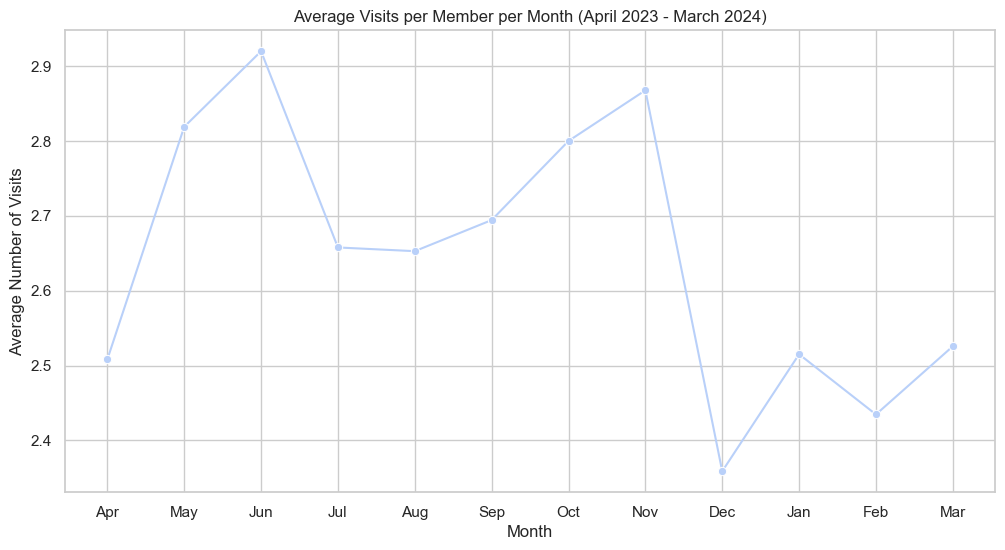

In [111]:
# setting the grid and palette
sns.set(style="whitegrid")
palette = sns.color_palette("coolwarm", 7)  # Using a diverging palette

# calculating average visits per member per month
avg_visits_per_member = data.groupby(['month'])['number_of_visits'].mean().reset_index()

# month names
avg_visits_per_member['month_name'] = avg_visits_per_member['month'].map(month_order)

# month order
avg_visits_per_member['month_name'] = pd.Categorical(avg_visits_per_member['month_name'], categories=list(month_order.values()), ordered=True)

# plotting average visits per member per month
plt.figure(figsize=(12, 6))
sns.lineplot(x='month_name', y='number_of_visits', data=avg_visits_per_member, marker='o', color=palette[2])
plt.xlabel('Month')
plt.ylabel('Average Number of Visits')
plt.title('Average Visits per Member per Month (April 2023 - March 2024)')
plt.grid(True)
plt.show()

The analysis of average visits per member per month from April 2023 to March 2024 reveals distinct seasonal patterns. Participation peaks in June with nearly 3 visits per member, followed closely by May and November. Conversely, December sees the lowest average visits at about 2.4 per member, likely due to the holiday season. There is a notable increase in average visits from April to June, followed by a gradual decline and minor fluctuations until December. Post-December, there is a recovery in January, with a slight upward trend continuing into March.

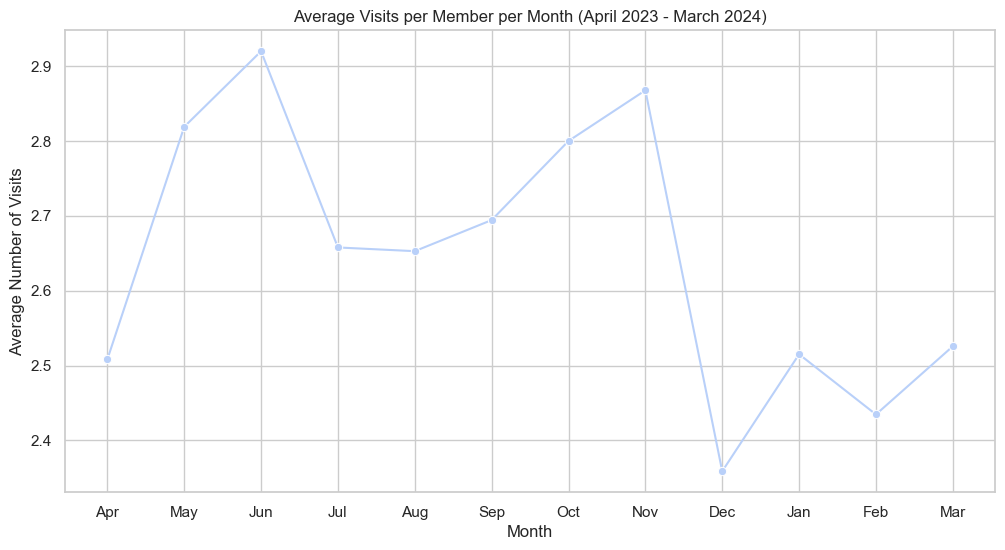

In [114]:
# setting the grid and palette
sns.set(style="whitegrid")
palette = sns.color_palette("coolwarm", 7)  # Using a diverging palette

avg_visits_per_member = data.groupby(['month', 'member_id'])['number_of_visits'].sum().groupby('month').mean().reset_index()
avg_visits_per_member['month_name'] = avg_visits_per_member['month'].map(month_order)
avg_visits_per_member['month_name'] = pd.Categorical(avg_visits_per_member['month_name'], categories=list(month_order.values()), ordered=True)
plt.figure(figsize=(12, 6))
sns.lineplot(x='month_name', y='number_of_visits', data=avg_visits_per_member, marker='o', color=palette[2])
plt.xlabel('Month')
plt.ylabel('Average Number of Visits')
plt.title('Average Visits per Member per Month (April 2023 - March 2024)')
plt.grid(True)
plt.show()

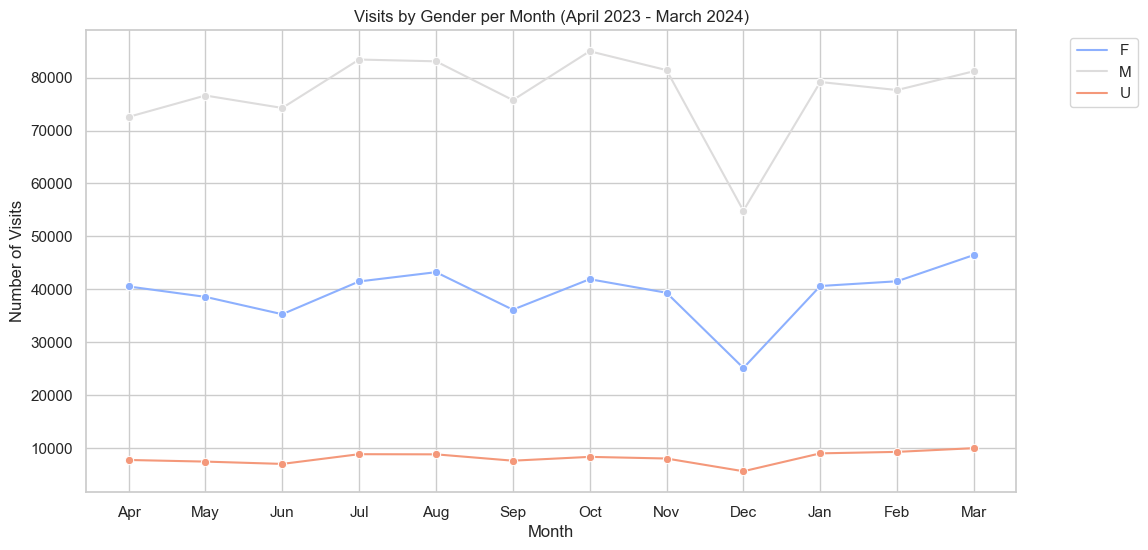

In [116]:
# aggregate the data by gender and month
visits_by_gender = data.groupby(['gender', 'month'])['number_of_visits'].sum().reset_index()

# month names
visits_by_gender['month_name'] = visits_by_gender['month'].map(month_order)

# reordering months to start from April
visits_by_gender['month_name'] = pd.Categorical(visits_by_gender['month_name'], categories=list(month_order.values()), ordered=True)

# plotting visits by gender per month
plt.figure(figsize=(12, 6))
sns.lineplot(x='month_name', y='number_of_visits', hue='gender', data=visits_by_gender, marker='o', palette='coolwarm')
plt.xlabel('Month')
plt.ylabel('Number of Visits')
plt.title('Visits by Gender per Month (April 2023 - March 2024)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

The graph displays the number of badminton visits per month from April 2023 to March 2024, categorized by gender. It shows that male participants (M) consistently have the highest number of visits each month, peaking around 85,000 visits. Female participants (F) have a steady participation rate, fluctuating around 40,000 to 45,000 visits per month, with slight increases in July and March. Participants with unspecified gender (U) consistently have the lowest number of visits, averaging around 10,000 visits monthly. The data reveals a noticeable dip in December across all genders, likely due to the holiday season, with a subsequent recovery in January.

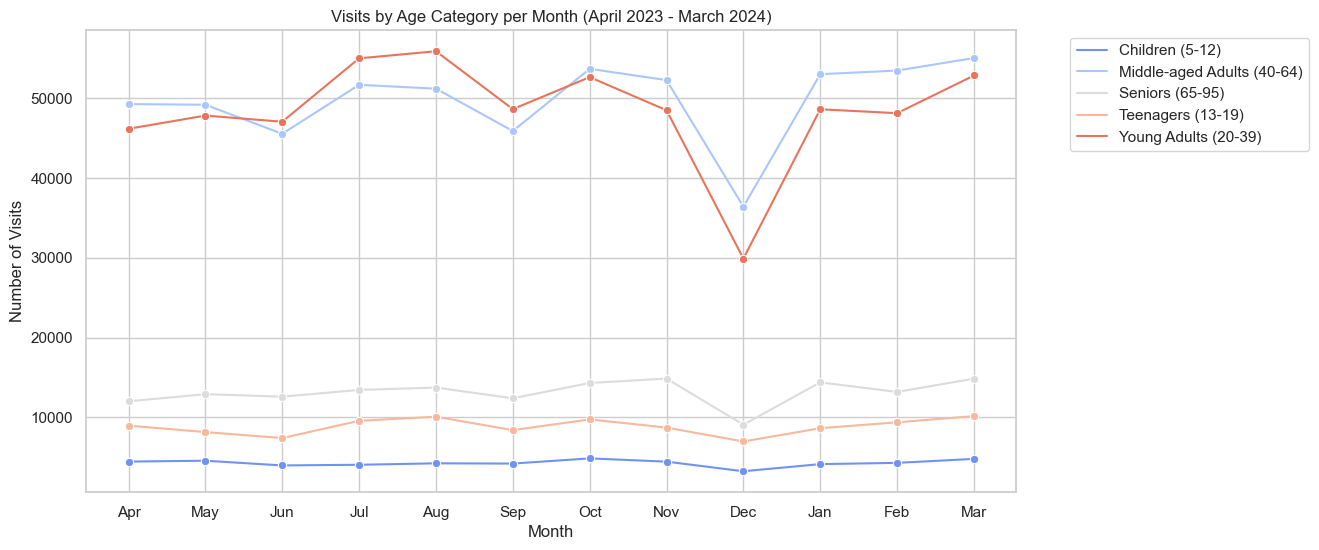

In [119]:
# converting the 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

# extracting month from the date
data['month'] = data['date'].dt.month

# month order
month_order = {4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec', 1: 'Jan', 2: 'Feb', 3: 'Mar'}

# aggregating the data by age category and month
visits_by_age_category = data.groupby(['age_category', 'month'])['number_of_visits'].sum().reset_index()

# month names
visits_by_age_category['month_name'] = visits_by_age_category['month'].map(month_order)

# reordering months to start from April
visits_by_age_category['month_name'] = pd.Categorical(visits_by_age_category['month_name'], categories=list(month_order.values()), ordered=True)

# plotting visits by age category per month
plt.figure(figsize=(12, 6))
sns.lineplot(x='month_name', y='number_of_visits', hue='age_category', data=visits_by_age_category, marker='o', palette='coolwarm')
plt.xlabel('Month')
plt.ylabel('Number of Visits')
plt.title('Visits by Age Category per Month (April 2023 - March 2024)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

The graph indicates that middle-aged adults (40-64) and young adults (20-39) consistently have the highest number of visits each month, with noticeable peaks around October and significant dips in December. Seniors (65-95), teenagers (13-19), and young children (5-12) show much lower and more stable participation throughout the year, with slight variations but no significant peaks or dips. Overall, adult age groups drive the majority of badminton participation, particularly outside of the holiday season.

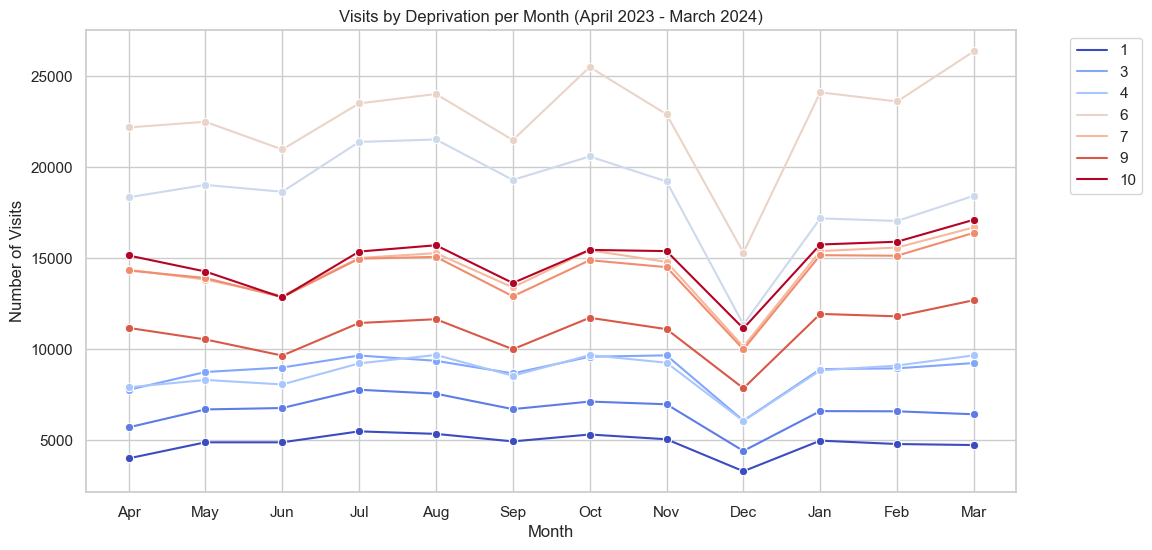

In [122]:
data['deprivation'] = data['deprivation'].astype(int)

# aggregating the data by deprivation and month
visits_by_deprivation = data.groupby(['deprivation', 'month'])['number_of_visits'].sum().reset_index()

# adjusting month names
visits_by_deprivation['month_name'] = visits_by_deprivation['month'].map(month_order)

# reordering months to start from April
visits_by_deprivation['month_name'] = pd.Categorical(visits_by_deprivation['month_name'], categories=list(month_order.values()), ordered=True)

# plotting visits by deprivation per month
plt.figure(figsize=(12, 6))
sns.lineplot(x='month_name', y='number_of_visits', hue='deprivation', data=visits_by_deprivation, marker='o', palette='coolwarm')
plt.xlabel('Month')
plt.ylabel('Number of Visits')
plt.title('Visits by Deprivation per Month (April 2023 - March 2024)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

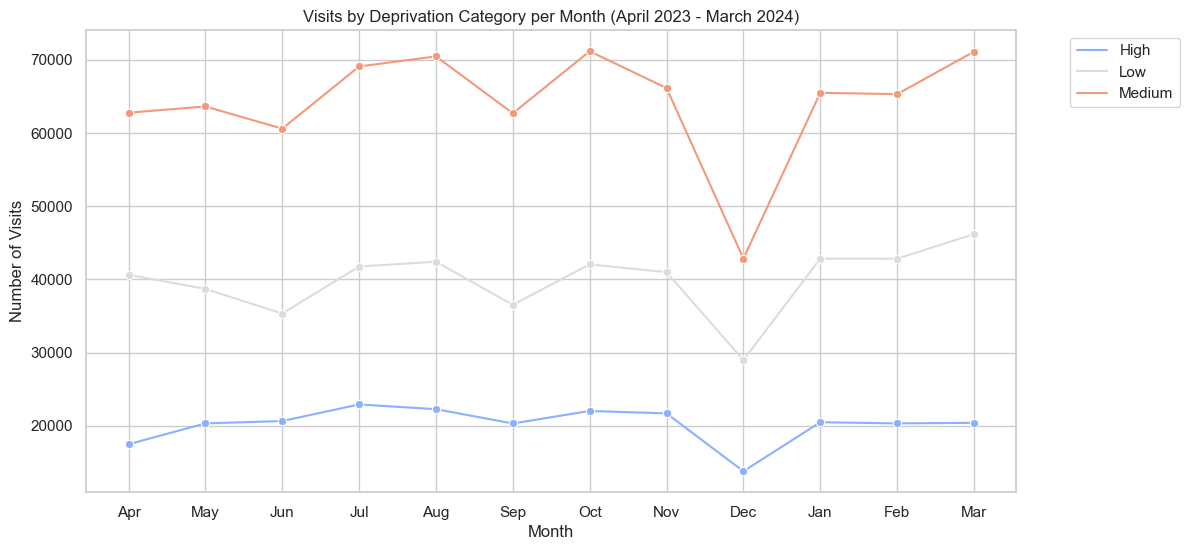

In [125]:
# aggregating the data by deprivation category and month
visits_by_deprivation_category = data.groupby(['deprivation_category', 'month'])['number_of_visits'].sum().reset_index()

# adjusting month names
visits_by_deprivation_category['month_name'] = visits_by_deprivation_category['month'].map(month_order)

# reordering months to start from April
visits_by_deprivation_category['month_name'] = pd.Categorical(visits_by_deprivation_category['month_name'], categories=list(month_order.values()), ordered=True)

# plotting visits by deprivation category per month
plt.figure(figsize=(12, 6))
sns.lineplot(x='month_name', y='number_of_visits', hue='deprivation_category', data=visits_by_deprivation_category,palette='coolwarm', marker='o')
plt.xlabel('Month')
plt.ylabel('Number of Visits')
plt.title('Visits by Deprivation Category per Month (April 2023 - March 2024)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

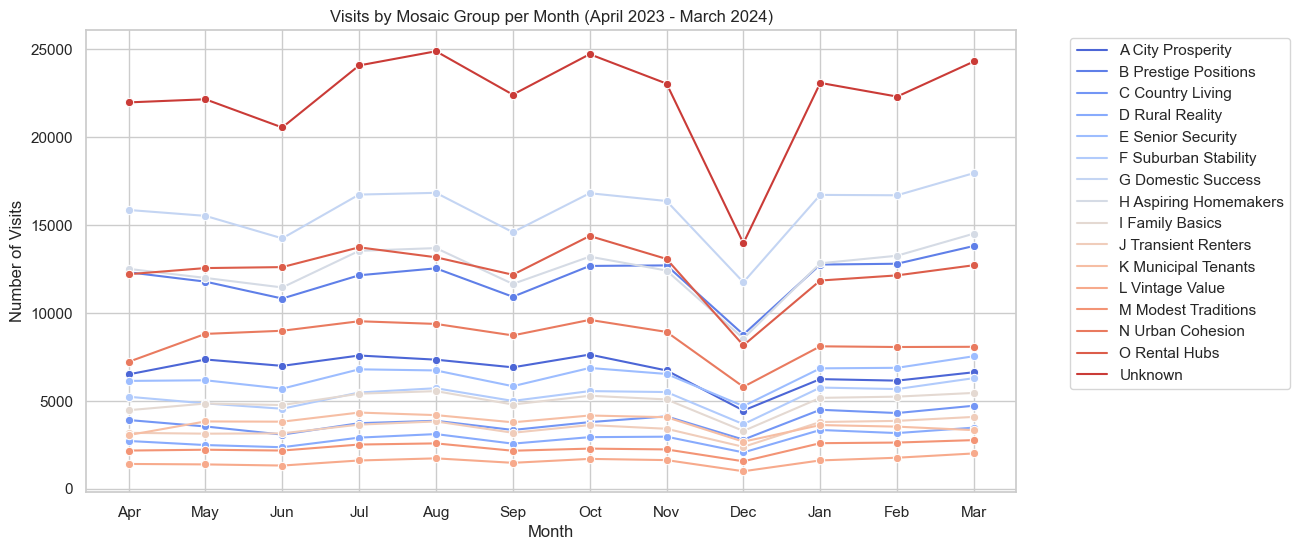

In [127]:
# aggregating the data by mosaic group and month
visits_by_mosaic_group = data.groupby(['mosaic', 'month'])['number_of_visits'].sum().reset_index()

# adjusting month names
visits_by_mosaic_group['month_name'] = visits_by_mosaic_group['month'].map(month_order)

# reordering months to start from April
visits_by_mosaic_group['month_name'] = pd.Categorical(visits_by_mosaic_group['month_name'], categories=list(month_order.values()), ordered=True)

# plotting visits by mosaic group per month
plt.figure(figsize=(12, 6))
sns.lineplot(x='month_name', y='number_of_visits', hue='mosaic', data=visits_by_mosaic_group, marker='o', palette='coolwarm')
plt.xlabel('Month')
plt.ylabel('Number of Visits')
plt.title('Visits by Mosaic Group per Month (April 2023 - March 2024)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

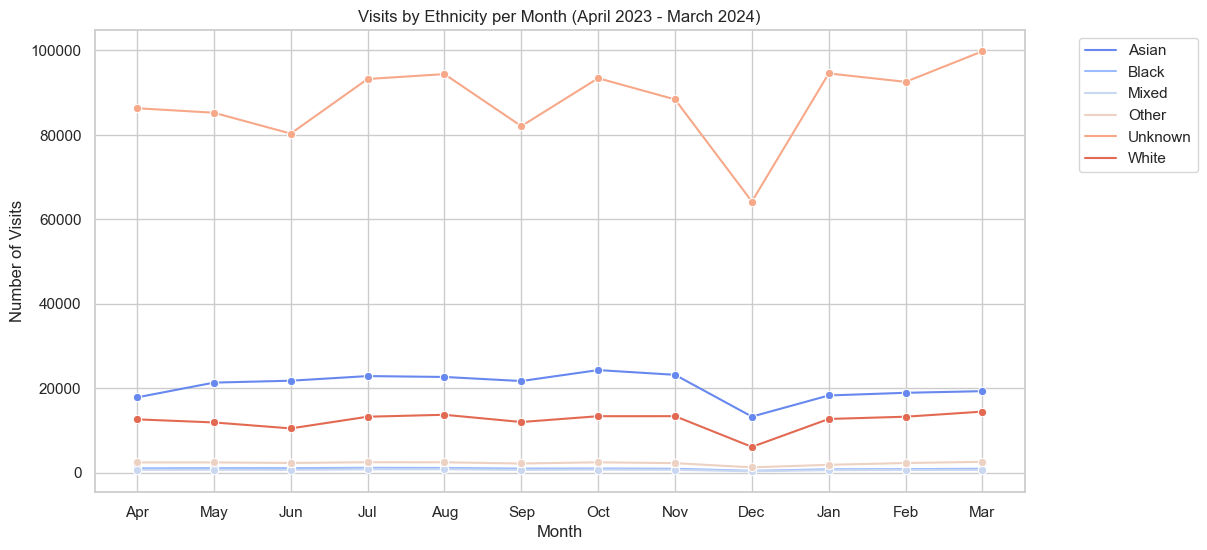

In [129]:
# aggregating the data by ethnic group and month
visits_by_eth = data.groupby(['ethnicity', 'month'])['number_of_visits'].sum().reset_index()

# adjusting month names
visits_by_eth['month_name'] = visits_by_eth['month'].map(month_order)

# reordering months to start from April
visits_by_eth['month_name'] = pd.Categorical(visits_by_eth['month_name'], categories=list(month_order.values()), ordered=True)

# plotting visits by ethnic group per month
plt.figure(figsize=(12, 6))
sns.lineplot(x='month_name', y='number_of_visits', hue='ethnicity', data=visits_by_eth,palette='coolwarm', marker='o')
plt.xlabel('Month')
plt.ylabel('Number of Visits')
plt.title('Visits by Ethnicity per Month (April 2023 - March 2024)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

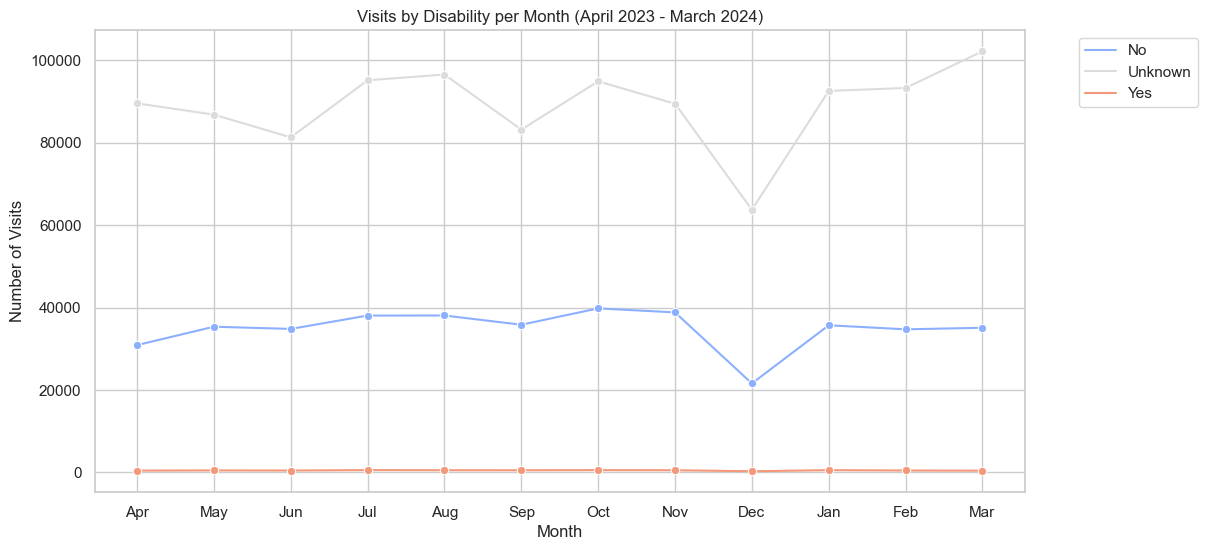

In [131]:
# aggregating the data by disability status and month
visits_by_dis = data.groupby(['disability', 'month'])['number_of_visits'].sum().reset_index()

# adjusting month names
visits_by_dis['month_name'] = visits_by_dis['month'].map(month_order)

# reordering months to start from April
visits_by_dis['month_name'] = pd.Categorical(visits_by_dis['month_name'], categories=list(month_order.values()), ordered=True)

# plotting visits by disability status per month
plt.figure(figsize=(12, 6))
sns.lineplot(x='month_name', y='number_of_visits', hue='disability', data=visits_by_dis,palette='coolwarm', marker='o')
plt.xlabel('Month')
plt.ylabel('Number of Visits')
plt.title('Visits by Disability per Month (April 2023 - March 2024)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [133]:
pd.DataFrame(seasonal_participation)

,season,number_of_visits
0,Autumn,383554
1,Spring,381198
2,Summer,385452
3,Winter,342855


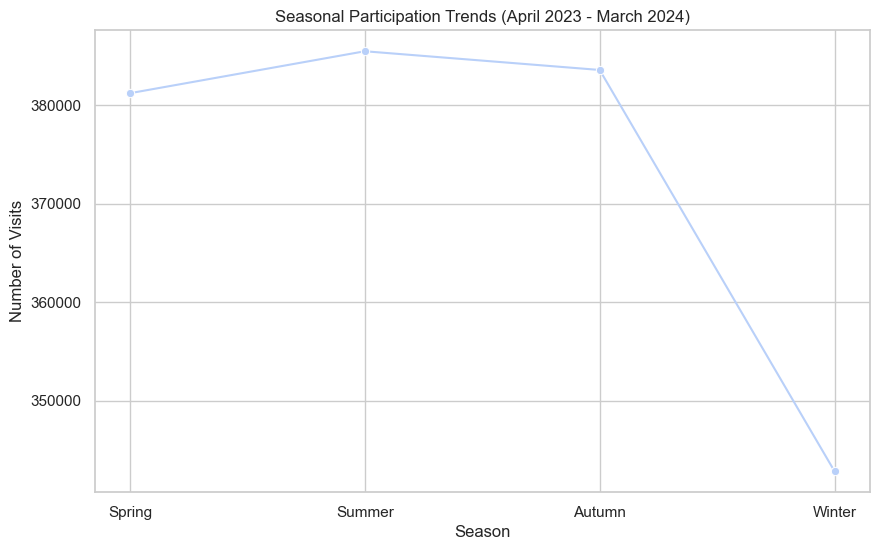

In [135]:
# ensuring the seasonal order is correct
season_order = ['Spring', 'Summer', 'Autumn', 'Winter']
seasonal_participation['season'] = pd.Categorical(seasonal_participation['season'], categories=season_order, ordered=True)
seasonal_participation = seasonal_participation.sort_values('season')
# setting the grid and palette
sns.set(style="whitegrid")
palette = sns.color_palette("coolwarm", 7)  # Using a diverging palette
# visualising seasonal participation trends
plt.figure(figsize=(10, 6))
sns.lineplot(x='season', y='number_of_visits', data=seasonal_participation, marker='o', color = palette[2])
plt.xlabel('Season')
plt.ylabel('Number of Visits')
plt.title('Seasonal Participation Trends (April 2023 - March 2024)')
plt.grid(True)
plt.show()

Participation peaks in summer, reaching nearly 395,000 visits, and remains high through autumn, slightly decreasing but still above 390,000 visits. Spring sees moderate participation with around 385,000 visits. There is a significant drop in winter, with participation falling to about 350,000 visits. This trend indicates that badminton participation is highest in summer and autumn and declines sharply during the winter season.

### 5.3 County-Level Analysis <a class="anchor" id="5.3"></a>

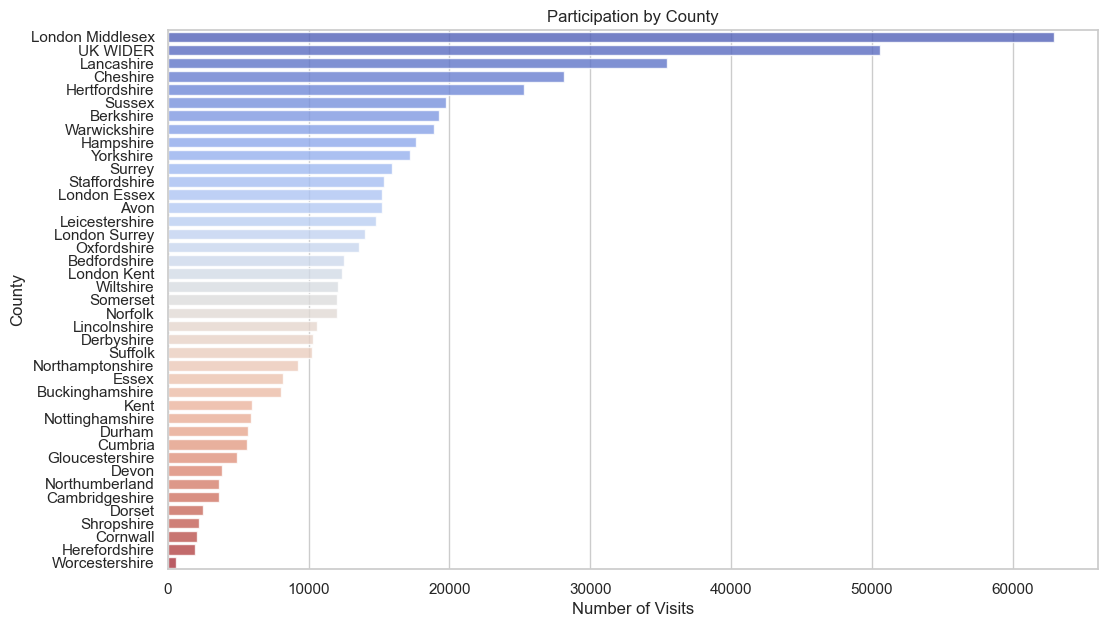

In [137]:
# setting the grid and palette
sns.set(style="whitegrid")
palette = sns.color_palette("coolwarm", 7)  # Using a diverging palette

county_visits = data['county'].value_counts().reset_index()
county_visits.columns = ['county', 'visits']

plt.figure(figsize=(12, 7))
sns.barplot(x='visits', y='county', data=county_visits, palette='coolwarm', alpha=0.8)
plt.title('Participation by County')
plt.xlabel('Number of Visits')
plt.ylabel('County')
plt.show()

The participation data, as shown in the first figure, highlights the disparities in badminton engagement across various counties. London Middlesex, UK WIDER, and Lancashire lead with the highest number of visits, each recording over 50,000 visits. 

In [140]:
# Filter out 'U' in gender and 'Unknown' entries in county
data_county = data[(data['county'] != 'UK WIDER') & (data['gender'] != 'U')]

# Aggregate total participants for each county
total_participants_per_county = data_county.groupby('county')['number_of_visits'].sum().sort_values(ascending=False)

# Extracting top 3 and bottom 3 counties
top_3_counties = total_participants_per_county.head(3)
bottom_3_counties = total_participants_per_county.tail(3)

# Combine top 3 and bottom 3 counties for further analysis
top_counties = top_3_counties.index
bottom_counties = bottom_3_counties.index

# Filter data for only top 3 and bottom 3 counties
filtered_data_top = data_county[data_county['county'].isin(top_counties)]
filtered_data_bottom = data_county[data_county['county'].isin(bottom_counties)]


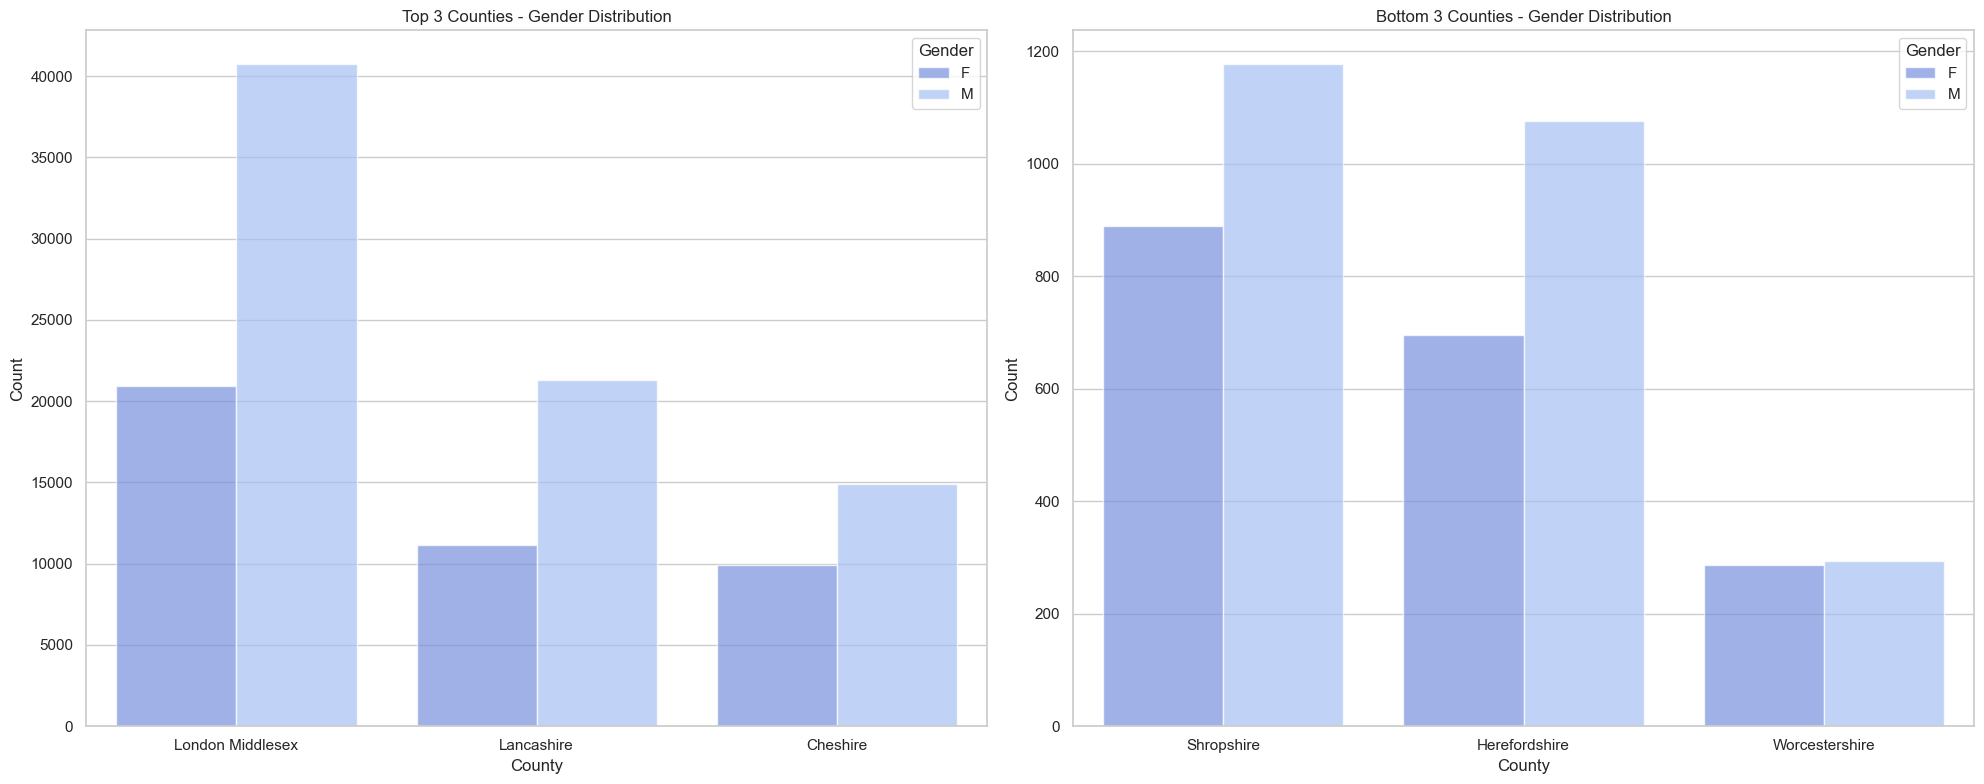

In [142]:
# Set the colormap
colormap = sns.color_palette("coolwarm", as_cmap=False)

# Figure 1: Gender Distribution
fig1, axes1 = plt.subplots(1, 2, figsize=(20, 8))

# Top 3 counties - Gender Distribution
sns.countplot(data=filtered_data_top, x='county', hue='gender', ax=axes1[0], palette=colormap, alpha=0.7)
axes1[0].set_title('Top 3 Counties - Gender Distribution')
axes1[0].set_xlabel('County')
axes1[0].set_ylabel('Count')
axes1[0].legend(title='Gender')

# Bottom 3 counties - Gender Distribution
sns.countplot(data=filtered_data_bottom, x='county', hue='gender', ax=axes1[1], palette=colormap, alpha=0.7)
axes1[1].set_title('Bottom 3 Counties - Gender Distribution')
axes1[1].set_xlabel('County')
axes1[1].set_ylabel('Count')
axes1[1].legend(title='Gender')

plt.tight_layout()
plt.show()

In the leading counties of London Middlesex, Lancashire, and Cheshire, male participants significantly outnumber female participants. On the other hand, the gender distribution in the bottom three counties is more balanced. Shropshire, Herefordshire, and Worcestershire show relatively equal participation rates between males and females, despite having lower overall engagement.

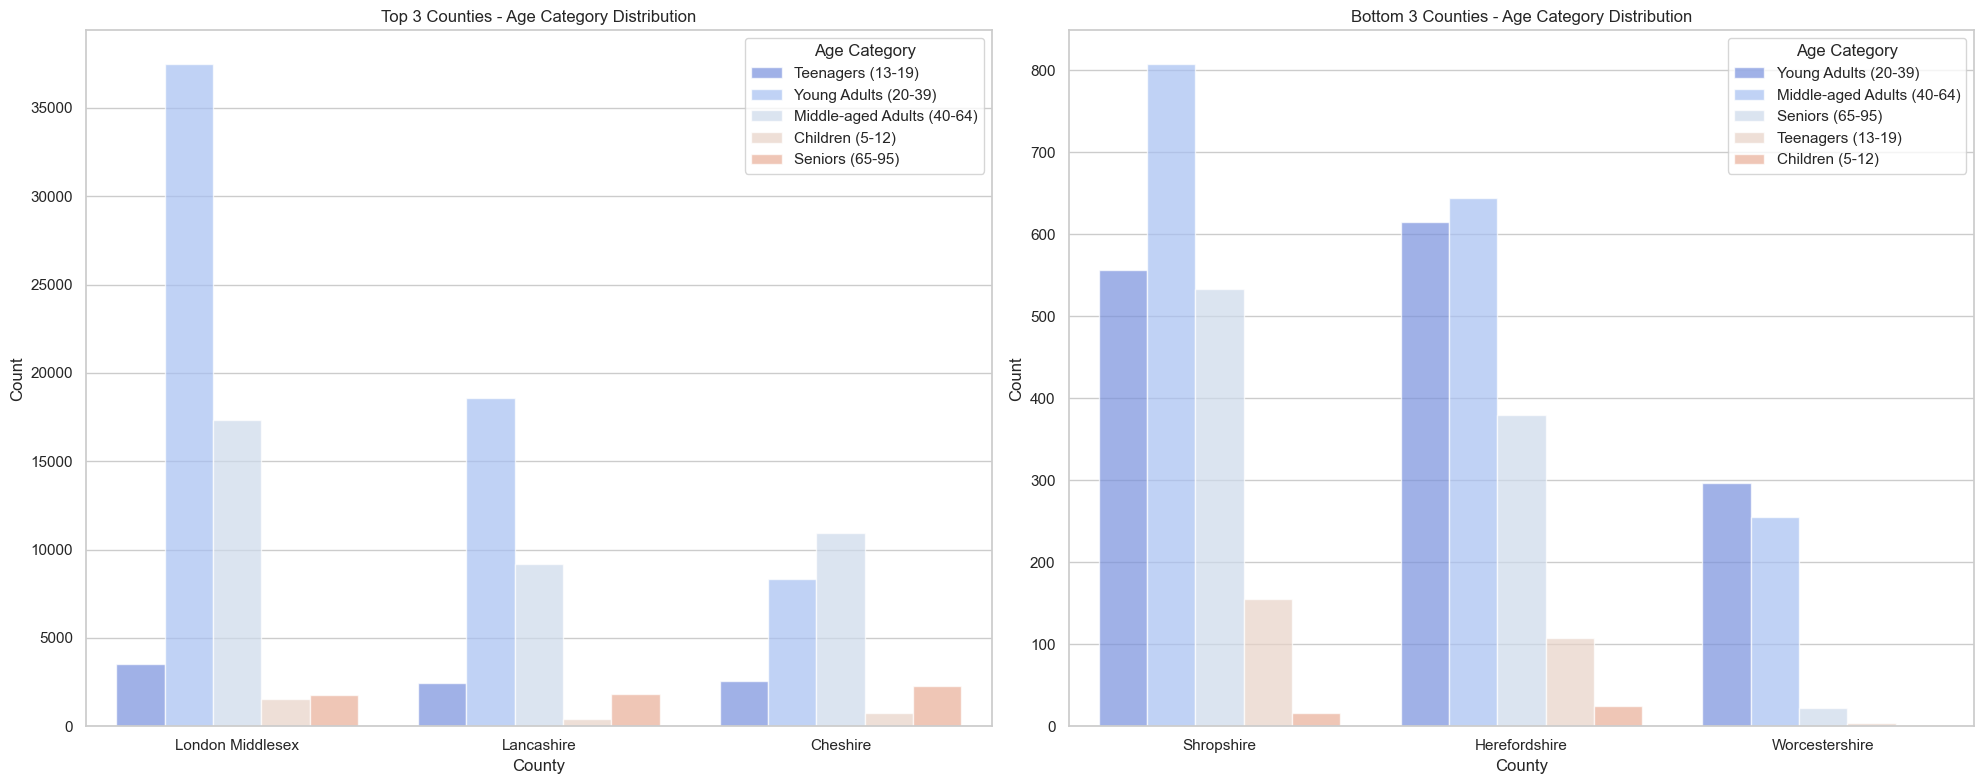

In [145]:
# Figure 2: Age Category Distribution
fig2, axes2 = plt.subplots(1, 2, figsize=(20, 8))

# Top 3 counties - Age Category Distribution
sns.countplot(data=filtered_data_top, x='county', hue='age_category', ax=axes2[0], palette=colormap, alpha=0.7)
axes2[0].set_title('Top 3 Counties - Age Category Distribution')
axes2[0].set_xlabel('County')
axes2[0].set_ylabel('Count')
axes2[0].legend(title='Age Category')

# Bottom 3 counties - Age Category Distribution
sns.countplot(data=filtered_data_bottom, x='county', hue='age_category', ax=axes2[1], palette=colormap, alpha=0.7)
axes2[1].set_title('Bottom 3 Counties - Age Category Distribution')
axes2[1].set_xlabel('County')
axes2[1].set_ylabel('Count')
axes2[1].legend(title='Age Category')

plt.tight_layout()
plt.show()

In London Middlesex, Lancashire, and Cheshire, young adults (20-39 years) and middle-aged adults (40-64 years) dominate the participation figures. These age groups show consistent engagement, highlighting a strong inclination towards regular badminton activities. In contrast, the bottom three counties—Shropshire, Herefordshire, and Worcestershire—show a different trend. Participation in these counties is more evenly spread across age groups, with a significant portion of visits coming from seniors (65-95 years) and young children (5-12 years). This distribution suggests that while these counties may lack high overall participation, they cater to a broader age range, including those often underrepresented in more populous areas.

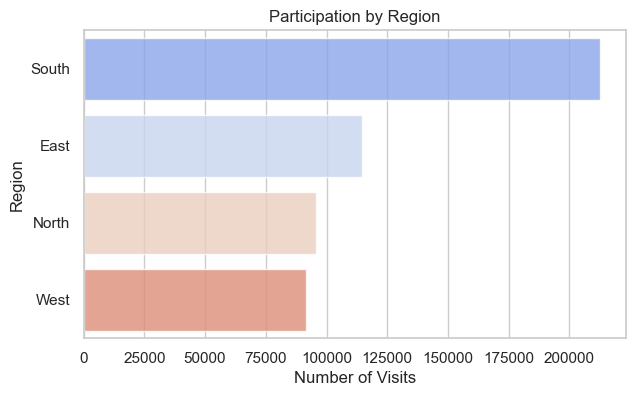

In [148]:
# Filter out 'U' in gender and 'Unknown' entries in county
data_region = data[data['region'] != 'UK Wider']

region_visits = data_region['region'].value_counts().reset_index()
region_visits.columns = ['region', 'visits']

plt.figure(figsize=(7, 4))
sns.barplot(x='visits', y='region', data=region_visits, palette='coolwarm', alpha=0.8)
plt.title('Participation by Region')
plt.xlabel('Number of Visits')
plt.ylabel('Region')
plt.show()

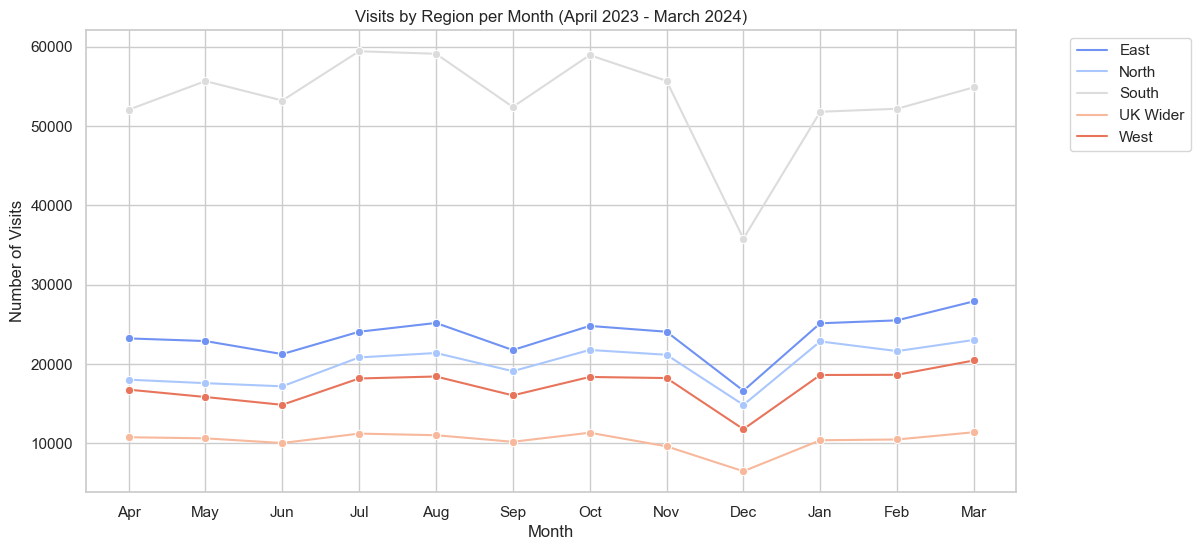

In [150]:
# aggregating the data by disability status and month
visits_by_region = data.groupby(['region', 'month'])['number_of_visits'].sum().reset_index()

# adjusting month names
visits_by_region['month_name'] = visits_by_region['month'].map(month_order)

# reordering months to start from April
visits_by_region['month_name'] = pd.Categorical(visits_by_region['month_name'], categories=list(month_order.values()), ordered=True)

# plotting visits by disability status per month
plt.figure(figsize=(12, 6))
sns.lineplot(x='month_name', y='number_of_visits', hue='region', data=visits_by_region,palette='coolwarm', marker='o')
plt.xlabel('Month')
plt.ylabel('Number of Visits')
plt.title('Visits by Region per Month (April 2023 - March 2024)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

## Conclusion <a class="anchor" id="conclusion"></a>

The hypothesis testing reveals notable disparities in participation rates between males and females, across different age groups, and among various socio-economic and ethnic groups. These insights are critical for developing targeted strategies to enhance engagement across diverse demographics.
Temporal analysis highlights seasonal trends, with participation peaking during summer and autumn and dropping significantly in winter. This suggests the need for targeted interventions during low-participation periods to maintain engagement.
County-level analysis underscores regional disparities, with certain counties exhibiting robust participation while others lag significantly. Understanding these geographical patterns is essential for resource allocation and program development to boost participation in underrepresented areas.